<h1>1. Import</h1>

In [1]:
#import des librairies
%pylab inline
import numpy as np 
import pandas as pd 
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from textblob import Word
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import re
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import FrenchStemmer
from spellchecker import SpellChecker
from textblob import TextBlob
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.svm import SVC
import sklearn.naive_bayes as nb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from xgboost import plot_importance, to_graphviz
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score, auc, precision_score, recall_score
from sklearn import feature_extraction, model_selection, svm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from sklearn.decomposition import TruncatedSVD
from gensim.utils import tokenize
from gensim.models import word2vec
from nltk.tokenize import sent_tokenize


Populating the interactive namespace from numpy and matplotlib


In [2]:
#ignore les warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
#chargement des données
#remplacement de None par NaN
#décimal avec un point plutôt qu'une virgule dans le dataframe afin que les variables soient de type float
df = pd.read_csv(r"C:\Users\utilisateur\Documents\Projet\ProjetNLP\booking.csv", na_values=['None'], decimal=',')

In [4]:
#affichage des 5 premières lignes du dataframe
df.head()

,nom,pays,favorite,date,titre,bons_points,mauvais_points,note,type_etablissement,lieu,note_etablissement
0,Caroline,Belgique,1.0,2018-07-30 00:00:00,Exceptionnel,"Établissement recent, propre, soigne, chouette...",Rien,10.0,Hôtel,Paris,8.5
1,Olivier51,France,0.0,2020-03-16 00:00:00,Fabuleux,"Accueil très chaleureux, chambre calme...tout ...",NaN,9.0,Hôtel,Paris,8.5
2,Marc,France,0.0,2020-03-11 00:00:00,Exceptionnel,Tout bié sauf le wifi catastrophiquement lent!...,NaN,9.6,Hôtel,Paris,8.5
3,Marie-claire,France,0.0,2020-03-08 00:00:00,Exceptionnel,NaN,Hôtel parfait. Quartier sympa.,10.0,Hôtel,Paris,8.5
4,Pierre,France,0.0,2020-03-06 00:00:00,Fabuleux,Excellent rapport qualité prix. Personnel très...,NaN,9.0,Hôtel,Paris,8.5


<h1>2. Exploration et nettoyage des données</h1>

In [5]:
#dimensions du dataframe
print('Le dataset a {} lignes et {} colonnes.'.format(df.shape[0], df.shape[1]))

Le dataset a 30946 lignes et 11 colonnes.


In [6]:
#affichage des variables
print('Les différents variables sont : {}.'.format(df.columns.tolist()))

Les différents variables sont : ['nom', 'pays', 'favorite', 'date', 'titre', 'bons_points', 'mauvais_points', 'note', 'type_etablissement', 'lieu', 'note_etablissement'].


In [7]:
#Existe-t-il des variables non renseignées?
df.isnull().values.any()

True

In [8]:
#affichage du nombre de valeurs manquantes selon chaque variable
df.isnull().sum()

nom                    395
pays                   452
favorite                15
date                   410
titre                  432
bons_points           2359
mauvais_points        8540
note                   410
type_etablissement      15
lieu                    15
note_etablissement      15
dtype: int64

In [9]:
#type de chaque variable
df.dtypes

nom                    object
pays                   object
favorite               object
date                   object
titre                  object
bons_points            object
mauvais_points         object
note                  float64
type_etablissement     object
lieu                   object
note_etablissement    float64
dtype: object

In [10]:
#statistiques descriptives du dataset
df.describe(include='all')

,nom,pays,favorite,date,titre,bons_points,mauvais_points,note,type_etablissement,lieu,note_etablissement
count,30551,30494,30931,30536,30514,28587,22406,30536.000000,30931,30931,30931.000000
unique,5838,127,2,1246,9611,22578,18151,NaN,11,18,NaN
top,Anonyme,France,0.0,2020-02-16 00:00:00,Bien,Ce client n'a pas laissé de commentaire.,Rien,NaN,Hôtel,Paris,NaN
freq,650,25991,30211,205,4763,1502,833,NaN,25927,12888,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.977607,NaN,NaN,7.903485
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.396143,NaN,NaN,0.701262
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,5.300000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.100000,NaN,NaN,7.300000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,NaN,8.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,NaN,NaN,8.400000


In [11]:
#suppression des accents
#cols = df.select_dtypes(include=[np.object]).columns
#df[cols] = df[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
#df

In [12]:
#fonction pour générer un nuage de mots
def wcloud(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
df.drop(['nom', 'pays', 'favorite', 'date', 'note', 'type_etablissement', 'lieu', 'note_etablissement'],1,inplace=True)
df.head()

,titre,bons_points,mauvais_points
0,Exceptionnel,"Établissement recent, propre, soigne, chouette...",Rien
1,Fabuleux,"Accueil très chaleureux, chambre calme...tout ...",NaN
2,Exceptionnel,Tout bié sauf le wifi catastrophiquement lent!...,NaN
3,Exceptionnel,NaN,Hôtel parfait. Quartier sympa.
4,Fabuleux,Excellent rapport qualité prix. Personnel très...,NaN


In [15]:
#suppression des Nan
df = df.fillna('')
#suppression de deux phrases récurrentes dans les données
df = df[df.bons_points != "Ce commentaire n'apparaît pas car il ne respecte pas notre charte."]
df = df[df.bons_points != "Ce client n'a pas laissé de commentaire."]

df = df[df.mauvais_points != "Ce commentaire n'apparaît pas car il ne respecte pas notre charte."]
df = df[df.mauvais_points != "Ce client n'a pas laissé de commentaire."]

In [16]:
#itération sur l'ensemble des lignes du dataframe, affichache de l'index et son commentaire associé
for index, row in df.iterrows():
    print('index: ', index, 'col sentences:', row['titre'])

index:  0 col sentences: Exceptionnel
index:  1 col sentences: Fabuleux 
index:  2 col sentences: Exceptionnel
index:  3 col sentences: Exceptionnel
index:  4 col sentences: Fabuleux 
index:  5 col sentences: Bien 
index:  6 col sentences: Superbe
index:  7 col sentences: Très bien
index:  8 col sentences: Très bien
index:  9 col sentences: Très bien
index:  10 col sentences: sympathique
index:  11 col sentences: Très bien
index:  12 col sentences: Fabuleux 
index:  13 col sentences: Très bien
index:  14 col sentences: Nous avons adoré visiter Paris
index:  15 col sentences: Bon séjour, nuits au calme, fenêtre ouverte sur Paris!
index:  16 col sentences: Parfait
index:  17 col sentences: super agreable
index:  18 col sentences: Bien 
index:  19 col sentences: Exceptionnel
index:  20 col sentences: Fabuleux 
index:  21 col sentences: Proche université Paris Panthéon Assas
index:  22 col sentences: Exceptionnel
index:  23 col sentences: Un petit bout de paradis en plein cœur de Paris
ind

index:  261 col sentences: hôtel très agréable mais un peu vieillissant au niveau salle de bain
index:  262 col sentences: Très bien
index:  263 col sentences: Agréable
index:  264 col sentences: Sans probleme
index:  265 col sentences: Bien 
index:  266 col sentences: Un peu déçue par rapport au prix
index:  267 col sentences: Nuit de transit satisfaisante
index:  268 col sentences: Bien 
index:  269 col sentences: Bon rapport qualité/prix
index:  270 col sentences: Très bien
index:  271 col sentences: Très correct
index:  272 col sentences: Agréable
index:  273 col sentences: Agréable séjour
index:  274 col sentences: Le séjour était fort charmant.
index:  275 col sentences: Bien 
index:  276 col sentences: Très bien
index:  277 col sentences: tres bien
index:  278 col sentences: Bon rapport qualité/prix
index:  279 col sentences: Très bien
index:  280 col sentences: Très bien
index:  281 col sentences: Très bien
index:  282 col sentences: Bien 
index:  283 col sentences: Très bon ra

index:  595 col sentences: Très bien
index:  596 col sentences: Très bon rapport qualité prix
index:  597 col sentences: Séjour agréable, simple et facilité par un accueil au top
index:  598 col sentences: Très chouette!
index:  599 col sentences: Parfait
index:  600 col sentences: Fabuleux 
index:  601 col sentences: Exceptionnel
index:  602 col sentences: Très chouette petit hôtel à l'ambiane chaleureuse et aux prestations impeccables. Parfait.
index:  603 col sentences: hotel agréable , bien situé avec un rapport qualité / prix satisfaisant
index:  604 col sentences: Parfait pour un séjour en cœur de ville
index:  605 col sentences: Très bien
index:  606 col sentences: Super
index:  607 col sentences: Très agréable
index:  608 col sentences: Fabuleux 
index:  609 col sentences: Exceptionnel
index:  610 col sentences: Un hôtel à la déco originale et chaleureuse, très bien placé en plein de coeur de Paris.
index:  611 col sentences: Fabuleux 
index:  612 col sentences: Très bien
index

index:  786 col sentences: Très bien
index:  787 col sentences: Bien 
index:  788 col sentences: Parfait
index:  789 col sentences: Très bon séjour , hotel très bien placé , personnels très agréable
index:  790 col sentences: Exceptionnel
index:  791 col sentences: Exceptionnel
index:  792 col sentences: À 2 rues des Champs Elysées !
index:  793 col sentences: Très bien
index:  794 col sentences: Très bien
index:  795 col sentences: Bien dormi, bon accueil mais hors de prix eu égard aux prestations qui n'ont rien d'exceptionnel
index:  796 col sentences: Trés contente en genéral
index:  797 col sentences: Très bien
index:  798 col sentences: Très bien
index:  799 col sentences: Superbe
index:  800 col sentences: Bien 
index:  801 col sentences: hotel très bien situé,calme, propre et accueil exceptionnellement sympathique.
index:  802 col sentences: très bien placé et accueil convivial
index:  803 col sentences: Bon plan près des champs
index:  804 col sentences: Bien 
index:  805 col s

index:  1075 col sentences: Très bien
index:  1076 col sentences: Correct
index:  1077 col sentences: Bon 
index:  1078 col sentences: Petit hotel populaire, bon marché, très pratique, pour voyageur. Accro confort moderne s'abstenir.
index:  1079 col sentences: Parfait pour conquérir Paris mais mériterait un grand rafraîchissement car très ancien !!
index:  1080 col sentences: Bien 
index:  1081 col sentences: quelques ameliorations aménagement (monte charge- toilette)
index:  1082 col sentences: Bon rapport qualité prix
index:  1083 col sentences: Très bon rapport qualité-prix
index:  1084 col sentences: Séjour de 2 nuits réussi, à proximité de la rue de la Roquette ; ; ;
index:  1085 col sentences: Agréable
index:  1086 col sentences: Bien 
index:  1087 col sentences: Bon depannage
index:  1088 col sentences: Conton
index:  1089 col sentences: Adresse sympathique pour un rapport qualité/prix très intéressant.
index:  1090 col sentences: Déception
index:  1091 col sentences: Bien 
ind

index:  1362 col sentences: Exceptionnel
index:  1363 col sentences: Petit hôtel charme central
index:  1364 col sentences: Très bien
index:  1365 col sentences: Très bien
index:  1366 col sentences: Très bien
index:  1367 col sentences: Très bien
index:  1368 col sentences: Très bien
index:  1369 col sentences: Court, bon et efficace
index:  1370 col sentences: Bien 
index:  1371 col sentences: Nous reviendrons
index:  1372 col sentences: Superbe
index:  1373 col sentences: Exceptionnel
index:  1374 col sentences: Une petite bouffée d’air
index:  1375 col sentences: Très bien
index:  1376 col sentences: Calme, confort, sans chichi.
index:  1377 col sentences: Bien 
index:  1378 col sentences: 1 nuit à Paris
index:  1379 col sentences: 3 étoiles confortable et bien placé
index:  1380 col sentences: Bien 
index:  1381 col sentences: Séjour
index:  1382 col sentences: idéal pour un voyage d'affaires ou un court séjour- situation géographique et calme assurés
index:  1383 col sentences: H

index:  1682 col sentences: Je ne recommande pas du tout cet hotel
index:  1683 col sentences: je ne retournerais pas a l hotel bedford
index:  1684 col sentences: Agréable
index:  1685 col sentences: Décevant
index:  1686 col sentences: Agréable
index:  1687 col sentences: Joli mais impersonnel
index:  1688 col sentences: Meme si Bedford, francais 100%!
index:  1689 col sentences: A choisir uniquement si on aime l'ambiance "grand hôtel de sous-préfecture dans les années 50"
index:  1690 col sentences: Exceptionnel
index:  1691 col sentences: Très agreable
index:  1692 col sentences: Sympathique ! Je recommande pour un petit city trop sans aucun doute
index:  1693 col sentences: Fabuleux 
index:  1694 col sentences: Très bien
index:  1695 col sentences: Exceptionnel
index:  1696 col sentences: Excellent
index:  1697 col sentences: Hôtel agréable, bien situé.
index:  1698 col sentences: Bien 
index:  1699 col sentences: Bien 
index:  1700 col sentences: Bien 
index:  1701 col sentences:

index:  2152 col sentences: Très bien
index:  2153 col sentences: fonctionnel
index:  2154 col sentences: Très bien
index:  2155 col sentences: Agréable séjour
index:  2156 col sentences: Agréable
index:  2157 col sentences: Agréable.
index:  2158 col sentences: Bon mais peut mieux faire.
index:  2159 col sentences: Bien 
index:  2160 col sentences: Excellent séjour
index:  2161 col sentences: Bel hôtel avec un personnel au top
index:  2162 col sentences: L'hotel a correspondu à notre attente.
index:  2163 col sentences: Très bon séjour
index:  2164 col sentences: Correct !!
index:  2165 col sentences: Bien 
index:  2166 col sentences: Hôtel bien placé
index:  2167 col sentences: Agréable
index:  2168 col sentences: Moyen
index:  2169 col sentences: Bien placé et relativement confortable.
index:  2170 col sentences: Très bien
index:  2171 col sentences: Bien 
index:  2172 col sentences: Bien 
index:  2173 col sentences: Décevant
index:  2174 col sentences: Séjour agréable
index:  2175 

index:  2423 col sentences: Bon 
index:  2424 col sentences: Agréable
index:  2425 col sentences: Très gros hôtel très bien équipé pour séjour prof
index:  2426 col sentences: Bien 
index:  2427 col sentences: Passable
index:  2428 col sentences: agréable
index:  2429 col sentences: peux mieux faire
index:  2430 col sentences: Bien 
index:  2431 col sentences: Bien 
index:  2432 col sentences: C'était bien !
index:  2433 col sentences: Bon 
index:  2434 col sentences: Bien 
index:  2435 col sentences: Bien 
index:  2436 col sentences: Pas mal
index:  2437 col sentences: Bien 
index:  2438 col sentences: Très bien
index:  2439 col sentences: Dans l'ensemble correct
index:  2440 col sentences: Bon 
index:  2441 col sentences: Très moyen
index:  2442 col sentences: Sa vaut son prix
index:  2443 col sentences: Séjour agréable
index:  2444 col sentences: Bon rapport qualité-prix et bonne accessibilité pour la visite de Paris
index:  2445 col sentences: Week end à paris entre amis
index:  24

index:  2722 col sentences: Bien 
index:  2723 col sentences: Bien 
index:  2724 col sentences: Bien 
index:  2725 col sentences: Bon séjour
index:  2726 col sentences: Bien 
index:  2727 col sentences: Séjour très agréable. Personnel accueillant
index:  2728 col sentences: Rapport qualité prix assuré
index:  2729 col sentences: Bien 
index:  2730 col sentences: Moyen.
index:  2731 col sentences: Agréable
index:  2732 col sentences: Bien 
index:  2733 col sentences: correct
index:  2734 col sentences: Hôtel sommaire mais très correct au regard du tarif
index:  2735 col sentences: Bonne adresse
index:  2736 col sentences: Bien 
index:  2737 col sentences: Agréable et confortable
index:  2738 col sentences: Bien 
index:  2739 col sentences: Tres bien situé dans le quartier de Montmartre, et calme
index:  2740 col sentences: Bien 
index:  2741 col sentences: Qualité moyenne
index:  2742 col sentences: Très bien
index:  2743 col sentences: Nuit correcte vu le prix très démocratique de la c

index:  3000 col sentences: très agréable séjour aidé par le beau temps.
index:  3001 col sentences: Bon 
index:  3002 col sentences: Agréable
index:  3003 col sentences: Agréable
index:  3004 col sentences: Une nuit au calme après un long voyage en avion avant de repartir en TGV de Montparnasse
index:  3005 col sentences: Parfait pour un concert
index:  3006 col sentences: Très bien
index:  3007 col sentences: Ça va, bien
index:  3008 col sentences: Chambre familiale mais éloignée du métro et quartier pas très rassurant. A déconseiller en famille
index:  3009 col sentences: Très bien
index:  3010 col sentences: Bon séjour
index:  3011 col sentences: Établissement très correct dans l'ensemble
index:  3012 col sentences: Sympathique
index:  3013 col sentences: Bien 
index:  3014 col sentences: Très bien
index:  3015 col sentences: Très bien
index:  3016 col sentences: Peut faire mieux
index:  3017 col sentences: Déçue
index:  3018 col sentences: Correct
index:  3019 col sentences: Agréa

index:  3286 col sentences: Il ne faut pas être claustrophobe !
index:  3287 col sentences: Bien 
index:  3288 col sentences: Bon 
index:  3289 col sentences: Bon rapport qualité / prix
index:  3290 col sentences: Golobalement satisfaisant
index:  3291 col sentences: Très bien
index:  3292 col sentences: Agréable
index:  3293 col sentences: Bien 
index:  3294 col sentences: Agréable
index:  3295 col sentences: Bien 
index:  3296 col sentences: Bien 
index:  3297 col sentences: Très rapport qualité prix.
index:  3298 col sentences: Agréable
index:  3299 col sentences: Bien 
index:  3300 col sentences: Bien 
index:  3301 col sentences: Agréable
index:  3302 col sentences: Bon 
index:  3303 col sentences: Séjour passable
index:  3304 col sentences: Rapport qualité prix défavorable
index:  3305 col sentences: Bien mais sans plus
index:  3306 col sentences: Superbe
index:  3307 col sentences: Tout c'est bien passé
index:  3308 col sentences: Bien 
index:  3309 col sentences: Chambre simple 

index:  3555 col sentences: Bien 
index:  3556 col sentences: À méditer et pour petit budget
index:  3557 col sentences: Agréable
index:  3558 col sentences: Parfait pour mon séjour profissionnel!
index:  3559 col sentences: C etait tres bien ce serait encore mieux s il y avait une porte a la place du rideau dans la douche
index:  3560 col sentences: Bof...
index:  3561 col sentences: Très bien
index:  3562 col sentences: A oublié au plus vite
index:  3563 col sentences: Agréable
index:  3564 col sentences: Bien 
index:  3565 col sentences: Désagréable mais à retenter
index:  3566 col sentences: Bien situé mais hôtel délabré dont la propreté peut laisser à désirer
index:  3567 col sentences: Peut mieux faire!
index:  3568 col sentences: En ordre
index:  3569 col sentences: Bien pour une nuit voir 2 pas plus !
index:  3570 col sentences: Bien 
index:  3571 col sentences: ok pour un court sejour
index:  3572 col sentences: Bien 
index:  3573 col sentences: Hôtel sans chichi,parfait pour 

index:  3823 col sentences: Bien 
index:  3824 col sentences: Correct pour 1 ou 2 nuits
index:  3825 col sentences: Agréable
index:  3826 col sentences: Agréable
index:  3827 col sentences: Sympa mais pas très confortable
index:  3828 col sentences: Bien dans l'ensemble
index:  3829 col sentences: Agréable
index:  3830 col sentences: Pour un Petit séjour, juste pour avoir un point de chute.
index:  3831 col sentences: Agréable
index:  3832 col sentences: Fabuleux 
index:  3833 col sentences: Exceptionnel
index:  3834 col sentences: Sejour agreable avec de bons conseils.
index:  3835 col sentences: Très bon séjour
index:  3836 col sentences: Décevant
index:  3837 col sentences: Passable
index:  3838 col sentences: Fabuleux 
index:  3839 col sentences: sans rancune, mais je ne reviendrai pas
index:  3840 col sentences: Décevant
index:  3841 col sentences: Assez médiocre 
index:  3842 col sentences: Médiocre 
index:  3843 col sentences: Mauvais
index:  3844 col sentences: Exceptionnel
ind

index:  4100 col sentences: Assez médiocre 
index:  4101 col sentences: Très déçue. Je ne conseille pas et n'y retournerai pas.
index:  4102 col sentences: Mauvais rapport qualité / prix
index:  4103 col sentences: Décevant
index:  4104 col sentences: Exceptionnel
index:  4105 col sentences: Exceptionnel
index:  4106 col sentences: Prix correct aux portes de Paris
index:  4107 col sentences: n'eut été le souci de coronavirus, je passe toujours un bon séjour
index:  4108 col sentences: bon séjour contente
index:  4109 col sentences: Très bien
index:  4110 col sentences: Bon séjour.
index:  4111 col sentences: Bon 
index:  4112 col sentences: Bien 
index:  4113 col sentences: Bien 
index:  4114 col sentences: déçu de notre séjour dans cet hôtel
index:  4115 col sentences: Très bien
index:  4116 col sentences: Rapport qualite prix très bien!
index:  4117 col sentences: Très bien
index:  4118 col sentences: agréable séjour
index:  4119 col sentences: Très bien
index:  4120 col sentences: A

index:  4384 col sentences: CORRECT
index:  4385 col sentences: Bien 
index:  4386 col sentences: Pas de stress avec un Ibis
index:  4387 col sentences: Bien 
index:  4388 col sentences: Fabuleux 
index:  4389 col sentences: Très bien
index:  4390 col sentences: Très bon séjour
index:  4391 col sentences: J'y reviendrai
index:  4392 col sentences: Je reviendrai
index:  4393 col sentences: Agréable
index:  4394 col sentences: Très bien
index:  4395 col sentences: Fabuleux 
index:  4396 col sentences: POSITIF
index:  4397 col sentences: Fabuleux 
index:  4398 col sentences: Très simple mais efficace
index:  4399 col sentences: Satisfaisant
index:  4400 col sentences: Emplacement idéal pour un rapport qualité/prix imbattable. Petite chambre propre et moderne.
index:  4401 col sentences: Bien 
index:  4402 col sentences: pour dormir c'est bien
index:  4403 col sentences: Agréable c'est notre point de chute à chaque fois que nous allons sur Paris
index:  4404 col sentences: Bien 
index:  44

index:  4670 col sentences: Bien 
index:  4671 col sentences: Bien 
index:  4672 col sentences: Agréable malgré l'exiguité des chambres.
index:  4673 col sentences: un rapport qualité prix un peu insuffisant.
index:  4674 col sentences: Bien situé
index:  4675 col sentences: Hôtel moyen
index:  4676 col sentences: Passable
index:  4677 col sentences: Idéal pour 2 nuits
index:  4678 col sentences: Bien 
index:  4679 col sentences: Séjour de courte durée, un peu désagréable dû au bruit. Mais personnel accueillant.
index:  4680 col sentences: Juste pour transit d'une nuit pas plus
index:  4681 col sentences: Super séjour
index:  4682 col sentences: Bien 
index:  4683 col sentences: Séjour correct.
index:  4684 col sentences: Top
index:  4685 col sentences: Agréable
index:  4686 col sentences: Bien 
index:  4687 col sentences: rapport qualité-prix correct
index:  4688 col sentences: Bien 
index:  4689 col sentences: Bien 
index:  4690 col sentences: A recommander pour un court sejour
index

index:  4990 col sentences: Bien 
index:  4991 col sentences: Agréable
index:  4992 col sentences: Ibis budget, équipements et déco budget, mais établissement calme et silencieux, bien situé.
index:  4993 col sentences: Agréable
index:  4994 col sentences: Bien 
index:  4995 col sentences: Agréable
index:  4996 col sentences: Agréable
index:  4997 col sentences: Bien 
index:  4998 col sentences: Bien 
index:  4999 col sentences: Très bien
index:  5000 col sentences: Fabuleux 
index:  5001 col sentences: Pratique pour un court séjour
index:  5002 col sentences: Très bien
index:  5003 col sentences: Conforme à mes attentes
index:  5004 col sentences: Très bien
index:  5005 col sentences: Agréable
index:  5006 col sentences: Très bon séjour en famille
index:  5007 col sentences: Bien 
index:  5008 col sentences: Bien 
index:  5009 col sentences: Bien 
index:  5010 col sentences: Séjour parfait
index:  5011 col sentences: bien
index:  5012 col sentences: Bien 
index:  5013 col sentences: B

index:  5277 col sentences: Bien 
index:  5278 col sentences: bien situé
index:  5279 col sentences: Agréable
index:  5280 col sentences: Bien malgré la nuit trop bruyante!
index:  5281 col sentences: Bien 
index:  5282 col sentences: Bon 
index:  5283 col sentences: Bon séjour
index:  5284 col sentences: exactement ce qu'il me fallait
index:  5285 col sentences: Bien mais bruyant.
index:  5286 col sentences: Bien 
index:  5287 col sentences: Hôtel convenable, petite chambre bien située sans attrait particulier
index:  5288 col sentences: Séjour agréable.
index:  5289 col sentences: Agréable
index:  5290 col sentences: Bien 
index:  5291 col sentences: Très satisfaite je reviendrai
index:  5292 col sentences: Bon 
index:  5293 col sentences: Correct.
index:  5294 col sentences: Très bien
index:  5295 col sentences: Conforme à mes attentes
index:  5296 col sentences: Bon 
index:  5297 col sentences: Très bien
index:  5298 col sentences: Agréable
index:  5299 col sentences: Du bon et du 

index:  5561 col sentences: Passable
index:  5562 col sentences: ...
index:  5563 col sentences: Agréable
index:  5564 col sentences: Bien 
index:  5565 col sentences: Assez agréable 😊
index:  5566 col sentences: Déçu de ne pas avoir les équipements annoncés surtout le parking !
index:  5567 col sentences: Hôtel à recommander
index:  5568 col sentences: Agréable
index:  5569 col sentences: Bon 
index:  5570 col sentences: Fort déçus !!! Rapport qualite/prix : 0
index:  5571 col sentences: bon rapport qualité,prix
index:  5572 col sentences: Agréable
index:  5573 col sentences: très bon
index:  5574 col sentences: Bien 
index:  5575 col sentences: Séjour de 3 nuits
index:  5576 col sentences: a ne jamais recommencer
index:  5577 col sentences: J'ai apprécié de passer ma soirée à l'extérieur !!!
index:  5578 col sentences: Bien 
index:  5579 col sentences: Correct
index:  5580 col sentences: Bon
index:  5581 col sentences: WE du 1er Novembre à Paris
index:  5582 col sentences: Passable
i

index:  5851 col sentences: Pratique mais trop bruyant
index:  5852 col sentences: très pratique pour un transit, ce qui était mon cas
index:  5853 col sentences: Bien 
index:  5854 col sentences: Correct qualité prix.
index:  5855 col sentences: Bon rapport qualité prix
index:  5856 col sentences: Assez bien !
index:  5857 col sentences: Hotel économique et confortable pour seulement y dormir et s'y rafraichir lors d'un séjour à Paris
index:  5858 col sentences: Agréable
index:  5859 col sentences: Passable
index:  5860 col sentences: Bien 
index:  5861 col sentences: Parfait
index:  5862 col sentences: Conforme à la réservation
index:  5863 col sentences: Excellent
index:  5864 col sentences: Rapport qualité prix correct
index:  5865 col sentences: Exceptionnel
index:  5866 col sentences: Superbe
index:  5867 col sentences: Très bien
index:  5868 col sentences: Agréable.
index:  5869 col sentences: Bien 
index:  5870 col sentences: Bien 
index:  5871 col sentences: J y retournerai
in

index:  6134 col sentences: 1 nuit à Paris
index:  6135 col sentences: 3 étoiles confortable et bien placé
index:  6136 col sentences: Bien 
index:  6137 col sentences: Séjour
index:  6138 col sentences: idéal pour un voyage d'affaires ou un court séjour- situation géographique et calme assurés
index:  6139 col sentences: Hotel très pratique si on va a Roland Garros ce qui est notre cas.
index:  6140 col sentences: Hotel confortable et très bien placé mais difficile d'accès (escaliers)
index:  6141 col sentences: Bien 
index:  6142 col sentences: Agréable
index:  6143 col sentences: Super pour business
index:  6144 col sentences: Je reviendrai
index:  6145 col sentences: Très bien
index:  6146 col sentences: Exceptionnel
index:  6147 col sentences: C’était bien passer
index:  6148 col sentences: Bien 
index:  6149 col sentences: Bien 
index:  6150 col sentences: Exceptionnel
index:  6151 col sentences: Bien 
index:  6152 col sentences: Très bien
index:  6153 col sentences: Super rappor

index:  6461 col sentences: Pfff
index:  6462 col sentences: Correct
index:  6463 col sentences: Accueil sympa malgré hôtel vétuste.
index:  6464 col sentences: Escapade à Paris
index:  6465 col sentences: Satisfaisant dans l'ensemble.
index:  6466 col sentences: Chambre avec charme ancien super bien "home-stagée". Petit déj beaucoup trop basique dommage
index:  6467 col sentences: Très bien
index:  6468 col sentences: Accueil agréable bon petit déjeuner mais gâché par le bruit la nuit
index:  6469 col sentences: Propre!
index:  6470 col sentences: Pas agréable
index:  6471 col sentences: Hôtel pratique et agréable
index:  6472 col sentences: Agréable
index:  6473 col sentences: Prix affiché en chambre trop élevé par rapport aux prestations donc voir offre Booking
index:  6474 col sentences: Séjour agréable sans mauvaise surprise en dehors du manque d'ascenseur. Hôtel propre et accueillant
index:  6475 col sentences: Hôtel bien situé, agréable avec un bon rapport qualité prix
index:  6

index:  6751 col sentences: Bien 
index:  6752 col sentences: Agréable
index:  6753 col sentences: Très bien
index:  6754 col sentences: Exceptionnel
index:  6755 col sentences: HOTEL SIMPLE MAIS TRES AGREABLE
index:  6756 col sentences: Hôtel pratique et confortable
index:  6757 col sentences: Bon rapport qualité/prix
index:  6758 col sentences: Très bien
index:  6759 col sentences: Bien 
index:  6760 col sentences: Bien 
index:  6761 col sentences: Très bien
index:  6762 col sentences: Bon séjour
index:  6763 col sentences: Hôtel efficace, propre accueillant a proximité du métro
index:  6764 col sentences: Hôtel Nation Montmartre
index:  6765 col sentences: Bien 
index:  6766 col sentences: Voyage du 20 au 23 février 2020
index:  6767 col sentences: Bien
index:  6768 col sentences: Excellent rapport qualité prix, personnel très agréable
index:  6769 col sentences: Très bien
index:  6770 col sentences: Bien 
index:  6771 col sentences: Super
index:  6772 col sentences: Très bien
index

index:  7031 col sentences: Excellent, à recommander !
index:  7032 col sentences: Bien 
index:  7033 col sentences: Mon mari et moi avons particulièrement apprécié cette étape
index:  7034 col sentences: Excellent
index:  7035 col sentences: Bien 
index:  7036 col sentences: Bien 
index:  7037 col sentences: Exceptionnel
index:  7038 col sentences: TRÈS BON SEJOUR
index:  7039 col sentences: Un hôtel idéal pour un séjour de luxe !
index:  7040 col sentences: Exceptionnel
index:  7041 col sentences: Exceptionnel
index:  7042 col sentences: Très bien
index:  7043 col sentences: Exceptionnel
index:  7044 col sentences: Fabuleux 
index:  7045 col sentences: Très agréable
index:  7046 col sentences: Superbe
index:  7047 col sentences: Bien 
index:  7048 col sentences: Confort et silence en mode un peu vintage
index:  7049 col sentences: Belle surprise
index:  7050 col sentences: Bien 
index:  7051 col sentences: Parfait
index:  7052 col sentences: Exceptionnel
index:  7053 col sentences: p

index:  7371 col sentences: très bon séjour
index:  7372 col sentences: Très bien
index:  7373 col sentences: Chambre confortable et super petit déjeuner !!!
index:  7374 col sentences: Je recommande
index:  7375 col sentences: Exceptionnel
index:  7376 col sentences: Superbe
index:  7377 col sentences: Très bon séjour hôtel à recommander
index:  7378 col sentences: Rapport qualité prix parfait
index:  7379 col sentences: Très bien mais pour le calme prendre chambre sur cour
index:  7380 col sentences: Très bien
index:  7381 col sentences: Tres bon rapport qualité/ prix
index:  7382 col sentences: Une nuit sur Paris par obligation, rien à redire sur cet hôtel.
index:  7383 col sentences: Superbe
index:  7384 col sentences: un beau design de la chambre que nous apprécions....un petit déjeuner complet et en abondance...
index:  7385 col sentences: Exceptionnel
index:  7386 col sentences: Bien 
index:  7387 col sentences: j y retournerai sans soucis
index:  7388 col sentences: Endroit con

index:  7693 col sentences: Agréable
index:  7694 col sentences: Bien 
index:  7695 col sentences: Très bien
index:  7696 col sentences: Bien pour une nuit, pas plus.
index:  7697 col sentences: Bien 
index:  7698 col sentences: Une bonne alternative pour une nuit relais vers Roissy CDG
index:  7699 col sentences: Agréable
index:  7700 col sentences: Exactement ce que je cherchais comme petit hotel.
index:  7701 col sentences: Puce de lit, propreté à revoir !
index:  7702 col sentences: Agréable
index:  7703 col sentences: Idéal pour voyager
index:  7704 col sentences: Bien 
index:  7705 col sentences: Correct
index:  7706 col sentences: sinon correct
index:  7707 col sentences: Bien 
index:  7708 col sentences: Bof
index:  7709 col sentences: Bien pour un court séjour
index:  7710 col sentences: Bon 
index:  7711 col sentences: Bon 
index:  7712 col sentences: Bon sejour
index:  7713 col sentences: Bon 
index:  7714 col sentences: Pour une nuit, de passage, c'est correct.
index:  7715

index:  8083 col sentences: Excellent rapport qualité-prix
index:  8084 col sentences: Fabuleux 
index:  8085 col sentences: idéal pour passé un moment de détente accueillis par une équipe jeune et professionnelle.
index:  8086 col sentences: excellent stAY I would choose it again
index:  8087 col sentences: nuit très réparatrice!
index:  8088 col sentences: Génial
index:  8089 col sentences: Exceptionnel
index:  8090 col sentences: Exceptionnel
index:  8091 col sentences: Presque parfait!
index:  8092 col sentences: Exceptionnel
index:  8093 col sentences: Très bien à tout point de vue
index:  8094 col sentences: Séjour court mais très bien
index:  8095 col sentences: Très bien
index:  8096 col sentences: Super hôtel, tendance et good vibe :)
index:  8097 col sentences: Exceptionnel
index:  8098 col sentences: Très bien
index:  8099 col sentences: Confort très bon rapport qualité prix
index:  8100 col sentences: Tres satisfait de notre séjour
index:  8101 col sentences: Fabuleux 
inde

index:  8353 col sentences: Un bon 3 etoiles
index:  8354 col sentences: Hotel vraiment à recommander. Privilégier les étages élevés pour plus de tranquillité
index:  8355 col sentences: Très bien
index:  8356 col sentences: Exceptionnel
index:  8357 col sentences: Hôtel agréable et très bon emplacement.
index:  8358 col sentences: Superbe
index:  8359 col sentences: j ai passé un agreable sejour dans cet hotel j y reviendrai avec plaisir
index:  8360 col sentences: Fabuleux 
index:  8361 col sentences: une belle surprise
index:  8362 col sentences: Fabuleux 
index:  8363 col sentences: Bien 
index:  8364 col sentences: Fabuleux 
index:  8365 col sentences: Fabuleux 
index:  8366 col sentences: Très bien
index:  8367 col sentences: Un petit hôtel très bien situé, très très bon rapport qualité/prix, à 5 min de la gare Montparnasse.
index:  8368 col sentences: Fabuleux 
index:  8369 col sentences: Bien 
index:  8370 col sentences: Très bien
index:  8371 col sentences: excellent séjour, n

index:  8631 col sentences: Bien 
index:  8632 col sentences: Très bien
index:  8633 col sentences: Bien 
index:  8634 col sentences: Très bon établissement très agréable
index:  8635 col sentences: Correct pour une nuit
index:  8636 col sentences: Bien 
index:  8637 col sentences: Bien 
index:  8638 col sentences: Pas de surprises.
index:  8639 col sentences: Bonnes prestations
index:  8640 col sentences: Bien 
index:  8641 col sentences: Bien 
index:  8642 col sentences: Bien 
index:  8643 col sentences: Bien 
index:  8644 col sentences: Bien 
index:  8645 col sentences: Bien 
index:  8646 col sentences: agréable, dans une chambre très propre et un lit et des oreillers très confortables
index:  8647 col sentences: Un peu bousculé
index:  8648 col sentences: Très bien
index:  8649 col sentences: Agréable
index:  8650 col sentences: Fabuleux 
index:  8651 col sentences: Très bien
index:  8652 col sentences: Séjour moyennement bien
index:  8653 col sentences: Tout parfait à part la plui

index:  8907 col sentences: Hôtel bien situé
index:  8908 col sentences: Fabuleux 
index:  8909 col sentences: Dans l'ensemble, très correct.
index:  8910 col sentences: Bien 
index:  8911 col sentences: Bien 
index:  8912 col sentences: En dépannage car le prix est tellement élevé
index:  8913 col sentences: Bon sejour
index:  8914 col sentences: très bon accueil et très bien
index:  8915 col sentences: bien situé accueil parfait mais trop chère par rapport à la SDB et au petit dejeuner
index:  8916 col sentences: Superbe
index:  8917 col sentences: Cher mais agréable
index:  8918 col sentences: Bien 
index:  8919 col sentences: Agréable
index:  8920 col sentences: Très satisfaisant et pratique pour passer 2 jours à Paris
index:  8921 col sentences: Pratique
index:  8922 col sentences: Très bien
index:  8923 col sentences: Agreable endroit
index:  8924 col sentences: Très bon hôtels
index:  8925 col sentences: Très pratique car bien situé !
index:  8926 col sentences: Bien 
index:  89

index:  9281 col sentences: excellent sejour
index:  9282 col sentences: Je recommmande vivement
index:  9283 col sentences: Fabuleux 
index:  9284 col sentences: Bien 
index:  9285 col sentences: excellent rapport qualité prix
index:  9286 col sentences: Très bien
index:  9287 col sentences: Chambres voisines trop mal isolées
index:  9288 col sentences: Bien 
index:  9289 col sentences: Parfait
index:  9290 col sentences: super
index:  9291 col sentences: Bien 
index:  9292 col sentences: Fabuleux 
index:  9293 col sentences: Merveilleux grâce à la gentillesse des réceptionniste 💓💓💓💓💓💓💓💓
index:  9294 col sentences: Séjour sympa mais trop court!
index:  9295 col sentences: Superbe
index:  9296 col sentences: Hôtel par fait, rapport qualité-prix imbattable, un accueil de très grande qualité
index:  9297 col sentences: Bien 
index:  9298 col sentences: Bien 
index:  9299 col sentences: Bien 
index:  9300 col sentences: Bien 
index:  9301 col sentences: Bien 
index:  9302 col sentences: B

index:  9572 col sentences: Exceptionnel
index:  9573 col sentences: Séjour de qualité dans le cadre d’une semaine pro
index:  9574 col sentences: Très bien
index:  9575 col sentences: Exceptionnel
index:  9576 col sentences: Fabuleux 
index:  9577 col sentences: Très bien
index:  9578 col sentences: TRÈS BIEN
index:  9579 col sentences: Fabuleux 
index:  9580 col sentences: Très bien
index:  9581 col sentences: Génial
index:  9582 col sentences: Exceptionnel
index:  9583 col sentences: Exceptionnel
index:  9584 col sentences: Bon sejour hormis quelques petits bémols ...
index:  9585 col sentences: Exceptionnel
index:  9586 col sentences: Bien 
index:  9587 col sentences: Très bien
index:  9588 col sentences: Très bien
index:  9589 col sentences: Très bien
index:  9590 col sentences: Chambre propre et agréable pour notre nuit.
index:  9591 col sentences: Très bien
index:  9592 col sentences: Très bien
index:  9593 col sentences: Hotel correct, ambiance agréable.
index:  9594 col senten

index:  9869 col sentences: Bon rapport qualité/prix et personnel à l’écoute (intervention rapide en cas de réclamation).
index:  9870 col sentences: Week-end prolongé
index:  9871 col sentences: Superbe
index:  9872 col sentences: Bien 
index:  9873 col sentences: Ideal para Porte Versailles, almorzo malo.
index:  9874 col sentences: correct bon rapport qualite prix
index:  9875 col sentences: Agréable
index:  9876 col sentences: Bien 
index:  9877 col sentences: bon séjour et si besoin nous y retournerons
index:  9878 col sentences: Bon séjour
index:  9879 col sentences: Bien 
index:  9880 col sentences: Bien 
index:  9881 col sentences: Bien 
index:  9882 col sentences: Bon séjour
index:  9883 col sentences: Bien 
index:  9884 col sentences: Peut mieux faire
index:  9885 col sentences: Agréable
index:  9886 col sentences: Bien 
index:  9887 col sentences: Bien 
index:  9888 col sentences: Bien 
index:  9889 col sentences: Très bien
index:  9890 col sentences: Bien 
index:  9891 col 

index:  10167 col sentences: Médiocre 
index:  10168 col sentences: Réjouissant
index:  10169 col sentences: Agréable
index:  10170 col sentences: Exceptionnel
index:  10171 col sentences: Exceptionnel
index:  10172 col sentences: Décevant à plusieurs égards.
index:  10173 col sentences: Passable
index:  10174 col sentences: Un bon séjour rapport qualité prix
index:  10175 col sentences: Très bon rapport qualité prix
index:  10176 col sentences: évitez cet hôtel
index:  10177 col sentences: Exceptionnel
index:  10178 col sentences: Agréable
index:  10179 col sentences: Exceptionnel
index:  10180 col sentences: Passable
index:  10181 col sentences: Exceptionnel
index:  10182 col sentences: Je ne referai pas cette expérience
index:  10183 col sentences: Decevant
index:  10184 col sentences: Exceptionnel
index:  10185 col sentences: Assez médiocre 
index:  10186 col sentences: Exceptionnel
index:  10187 col sentences: Très bien!
index:  10188 col sentences: Petit hôtel sympathique pour un

index:  10456 col sentences: Très bien
index:  10457 col sentences: Agréable
index:  10458 col sentences: A conseiller
index:  10459 col sentences: Bien 
index:  10460 col sentences: Agréable
index:  10461 col sentences: Bien 
index:  10462 col sentences: Bon dans l'ensemble, mais il est impératif d'apporter une amelioration à l'isolation phonique.
index:  10463 col sentences: Bon séjour dans l'ensemble.
index:  10464 col sentences: Très bien
index:  10465 col sentences: Chambre très propre et hôtel bien placé
index:  10466 col sentences: Super
index:  10467 col sentences: Très bien
index:  10468 col sentences: Bien 
index:  10469 col sentences: Bien 
index:  10470 col sentences: Bon séjour , hôtel à proximité gare de l'Est .
index:  10471 col sentences: Agréable
index:  10472 col sentences: L'ensemble est assez correct
index:  10473 col sentences: Agréable
index:  10474 col sentences: Bien 
index:  10475 col sentences: Bien 
index:  10476 col sentences: Bien 
index:  10478 col sentenc

index:  10735 col sentences: bon séjour
index:  10736 col sentences: Trés bien, je conseil malgrès l'insonorisation chambre vue sur ville.
index:  10737 col sentences: Bon rapport qualité prix mais effort a faire sur l'insonorisation chambres vue ville.
index:  10738 col sentences: Bien mais...
index:  10739 col sentences: Bien 
index:  10740 col sentences: Agréable
index:  10741 col sentences: Très bien
index:  10742 col sentences: Agréable
index:  10743 col sentences: Très bien
index:  10744 col sentences: Bon rapport qualité/prix, situation géographique pratique
index:  10745 col sentences: Bien 
index:  10746 col sentences: Très agréable
index:  10747 col sentences: Bien 
index:  10748 col sentences: Bien 
index:  10749 col sentences: Bien 
index:  10750 col sentences: Très bien
index:  10751 col sentences: une nuit pour le travail
index:  10752 col sentences: Très bien
index:  10753 col sentences: Hotell bien situe pout visiter Paris....7
index:  10754 col sentences: Hôtel correct

index:  11048 col sentences: Parfait
index:  11050 col sentences: Correct
index:  11051 col sentences: une chambre très confortable ,propreté impeccable , excellent rapport qualité prix pour un week end.
index:  11052 col sentences: Très bien
index:  11053 col sentences: Bien 
index:  11054 col sentences: bon sejour
index:  11055 col sentences: Sejour agréable
index:  11056 col sentences: Bien 
index:  11057 col sentences: Hotel bien situé
index:  11058 col sentences: Fabuleux 
index:  11059 col sentences: Rapport qualité prix imbattable pour un week-end
index:  11060 col sentences: Agréable
index:  11061 col sentences: accueil correct et chambre calme près du métro- rideau de fenêtre à changer!
index:  11062 col sentences: Fabuleux 
index:  11063 col sentences: Fabuleux 
index:  11064 col sentences: Séjour correct
index:  11065 col sentences: Propre et idéal pour un weekend.
index:  11066 col sentences: Très satisfait de cet établissement.
index:  11067 col sentences: Fabuleux 
index:

index:  11347 col sentences: Mon avis sur l'hôtel des Batignolles
index:  11348 col sentences: Très appréciable
index:  11349 col sentences: Exceptionnel
index:  11350 col sentences: Parfait
index:  11351 col sentences: Très bien
index:  11352 col sentences: Bien 
index:  11353 col sentences: Parfait Petit Hotel Parisien
index:  11354 col sentences: nous y retournerons avec plaisir
index:  11355 col sentences: Bien 
index:  11356 col sentences: Exceptionnel
index:  11357 col sentences: Fabuleux 
index:  11358 col sentences: les 4 étages sans ascenseur avec les lourds bagages
index:  11359 col sentences: Exceptionnel
index:  11360 col sentences: excellent sejour
index:  11361 col sentences: Fabuleux 
index:  11362 col sentences: Très agreable
index:  11363 col sentences: Bien 
index:  11364 col sentences: Très bien
index:  11365 col sentences: Très bien
index:  11366 col sentences: Fabuleux 
index:  11367 col sentences: Bon hôtel que je fréquente 2/3 fois par an depuis des années. Réhab

index:  11642 col sentences: Très bien
index:  11643 col sentences: Superbe
index:  11644 col sentences: Agréable
index:  11645 col sentences: Bon accueil mais bruyant
index:  11646 col sentences: Fabuleux 
index:  11647 col sentences: Bien 
index:  11648 col sentences: Très bien
index:  11649 col sentences: Accueil
index:  11650 col sentences: Bien 
index:  11651 col sentences: une belle adresse
index:  11652 col sentences: Bien 
index:  11653 col sentences: Agréable
index:  11654 col sentences: Bien mais un peu éloigné de l'endroit où je devais me rendre
index:  11655 col sentences: Reviendrai sur un étage plus élevé
index:  11656 col sentences: Pour une nuit ..pas plus.
index:  11657 col sentences: séjour satisfaisant
index:  11658 col sentences: Confortable, service aimable.
index:  11659 col sentences: Bien
index:  11660 col sentences: Bien
index:  11661 col sentences: Fabuleux 
index:  11662 col sentences: Bien 
index:  11663 col sentences: Bon rapport qualité-prix
index:  11664 

index:  11922 col sentences: Le meilleur 3 étoiles de la gare du nord
index:  11923 col sentences: Moins beau qu'il n'y parait, mais reste efficace.
index:  11924 col sentences: Un petit effort, mais une belle surprise
index:  11925 col sentences: Médiocre 
index:  11926 col sentences: Catastrophique
index:  11927 col sentences: Fabuleux 
index:  11928 col sentences: Exceptionnel
index:  11929 col sentences: hôtel has been....
index:  11930 col sentences: A notre demande changement pour une chambre plus confortable la 2ème nuit
index:  11931 col sentences: Assez médiocre 
index:  11932 col sentences: Assez médiocre 
index:  11933 col sentences: Décevant et bruyant
index:  11934 col sentences: Exceptionnel
index:  11935 col sentences: Hotel bien situé proche des gares, mais beaucoup trop bruyant côté rue... nuit blanche
index:  11936 col sentences: Assez médiocre 
index:  11937 col sentences: Assez médiocre 
index:  11938 col sentences: A recommander
index:  11939 col sentences: Passabl

index:  12195 col sentences: En dernier recours
index:  12196 col sentences: Passable
index:  12197 col sentences: heureusement que le personnel de l'acueuil est aimable
index:  12198 col sentences: Hôtel Porte de Montreuil
index:  12199 col sentences: Pas mal
index:  12200 col sentences: Juste un depannage !
index:  12201 col sentences: Je recommande pas
index:  12202 col sentences: Déçu
index:  12203 col sentences: Moyen mais bon emplacement
index:  12204 col sentences: Agréable
index:  12205 col sentences: pas cher mais pas intéressant
index:  12206 col sentences: Passable
index:  12207 col sentences: Une nuit, c'était largement suffisant !
index:  12208 col sentences: Passable
index:  12209 col sentences: Je ne pense pas y retourner malheureusement.
index:  12210 col sentences: Agréable
index:  12211 col sentences: Décevant
index:  12212 col sentences: Très moyen
index:  12213 col sentences: Hôtel à deconseiller
index:  12214 col sentences: Très bon séjour
index:  12215 col sentenc

index:  12536 col sentences: Très bon séjour
index:  12537 col sentences: Très bien
index:  12538 col sentences: Bien avec en plus un super concert
index:  12539 col sentences: Fabuleux 
index:  12540 col sentences: Très bien
index:  12541 col sentences: Bon accueil
index:  12542 col sentences: Bien 
index:  12543 col sentences: Agréable et idéalement placé !
index:  12544 col sentences: Bien 
index:  12545 col sentences: Pour une première : Bien
index:  12546 col sentences: Très bien
index:  12547 col sentences: Bien
index:  12548 col sentences: Fabuleux 
index:  12549 col sentences: Satisfait
index:  12550 col sentences: tres bon séjour dans un établissement sur la ligne 14 et face à la gare SNCF de Bercy
index:  12551 col sentences: Efficace et pratique
index:  12552 col sentences: Bien 
index:  12553 col sentences: 2 nuits très agréables, nous prendrons plaisir à revenir lors d'un prochain voyage dans la capitale.
index:  12554 col sentences: Hôtel idéalement placé pour un séjour à

index:  12834 col sentences: Établissement sympathique
index:  12835 col sentences: Super bon w end parisien !
index:  12836 col sentences: Bien 
index:  12837 col sentences: Superbe
index:  12838 col sentences: Bien 
index:  12839 col sentences: Bon 
index:  12840 col sentences: Bon 
index:  12841 col sentences: Bien 
index:  12842 col sentences: Superbe
index:  12843 col sentences: Agréable
index:  12844 col sentences: Bon 
index:  12845 col sentences: Bien 
index:  12846 col sentences: Très pratique pour son emplacement
index:  12847 col sentences: passable
index:  12848 col sentences: Agréable
index:  12849 col sentences: Parfait pour mon déplacement et pour une nuit. Merci au personnel pour son professionnalisme.
index:  12850 col sentences: Bien 
index:  12851 col sentences: Très bien
index:  12852 col sentences: Bien 
index:  12853 col sentences: Superbe
index:  12854 col sentences: Passable
index:  12855 col sentences: Passable
index:  12856 col sentences: Très satisfaisant par

index:  13130 col sentences: Bien 
index:  13131 col sentences: Au niveau d'un 2 étoiles.
index:  13132 col sentences: Aussi bien qu un hotel 4 étoiles ⭐️
index:  13133 col sentences: Bien 
index:  13134 col sentences: Très bien
index:  13135 col sentences: Emplacement idéal, prix défiant toute concurrence pour ce type d'hôtel
index:  13136 col sentences: Superbe
index:  13137 col sentences: Chambre spacieuse. Etablissement calme et très agréable.
index:  13138 col sentences: Fabuleux 
index:  13139 col sentences: Fabuleux 
index:  13140 col sentences: Bien 
index:  13141 col sentences: Superbe
index:  13142 col sentences: un 3 étoiles bien tenu ... à recommander.
index:  13143 col sentences: Toujours très bien
index:  13144 col sentences: Séjour agréable malgré les remarques.
index:  13145 col sentences: JE CONSEILLE VIVEMENT
index:  13146 col sentences: En ligne avec les attentes
index:  13147 col sentences: Parfait
index:  13148 col sentences: Agréable
index:  13149 col sentences: B

index:  13448 col sentences: Exceptionnel
index:  13449 col sentences: Agréable
index:  13450 col sentences: Agréable
index:  13451 col sentences: Exceptionnel
index:  13452 col sentences: Passable
index:  13453 col sentences: Dormir à Nice, sans plus
index:  13454 col sentences: Agréable
index:  13455 col sentences: Jeter l'argent par la fenêtre...
index:  13456 col sentences: Exceptionnel
index:  13457 col sentences: Excellent séjour , hôtel à recommander !
index:  13458 col sentences: Catastrophe
index:  13459 col sentences: Exceptionnel
index:  13460 col sentences: Propre et proche de toute commodité
index:  13461 col sentences: Passable
index:  13462 col sentences: Pas top pour un 3 étoiles
index:  13463 col sentences: Trés bien localisé, vraiment au centre de la ville! Je reviendrais!
index:  13464 col sentences: Exceptionnel
index:  13465 col sentences: Excellent
index:  13466 col sentences: très bien accueilli, nuit calme, bon repos
index:  13467 col sentences: Sejour en ville


index:  13731 col sentences: Très bon emplacement
index:  13732 col sentences: Séjour très court mais agreable
index:  13733 col sentences: Séjour moyen +
index:  13734 col sentences: C’était plutôt un bon séjour pour n’être restée que trois jours.
index:  13735 col sentences: Emplacement parfait mais la qualité aurai pu être meilleure
index:  13736 col sentences: Très agréable
index:  13737 col sentences: Très bien
index:  13738 col sentences: Bref mais agréable
index:  13739 col sentences: Bien 
index:  13740 col sentences: Agréable
index:  13741 col sentences: Bien 
index:  13742 col sentences: Bien 
index:  13743 col sentences: Bon plan!
index:  13744 col sentences: Bien 
index:  13745 col sentences: pas dormi de la nuit, trop de bruits
index:  13746 col sentences: Bien 
index:  13747 col sentences: Agréable
index:  13748 col sentences: Très Bien
index:  13749 col sentences: Bien 
index:  13750 col sentences: Agréable
index:  13751 col sentences: Bien 
index:  13752 col sentences: 

index:  14001 col sentences: agreable et sympa avec beaucoup de soleil
index:  14002 col sentences: Bien 
index:  14003 col sentences: bien
index:  14004 col sentences: Agréable
index:  14005 col sentences: Bien 
index:  14006 col sentences: Superbe
index:  14007 col sentences: Bien 
index:  14008 col sentences: agréable
index:  14009 col sentences: Bien
index:  14010 col sentences: Visite de la ville de Nice a été un enchantement.
index:  14011 col sentences: Globalement satisfaisant si vous voulez dormir en attendant votre avion le lendemain et pas plus.
index:  14012 col sentences: Un bon compromis pour visiter Nice à 2 pas de l'aéroport et du tramway vers le centre
index:  14013 col sentences: Très pratique et propre, fonctionnel, accueil à revoir.
index:  14014 col sentences: Bonne situation, petit déjeuner très satisfaisant mais personnel peu aimable.
index:  14015 col sentences: Agréable
index:  14016 col sentences: Essayez de baisser le prix
index:  14017 col sentences: Agréabl

index:  14292 col sentences: Exceptionnel
index:  14293 col sentences: Fabuleux 
index:  14294 col sentences: Bon séjour ! A très bientôt
index:  14295 col sentences: Exceptionnel
index:  14296 col sentences: Exceptionnel
index:  14297 col sentences: Exceptionnel
index:  14298 col sentences: Exceptionnel
index:  14299 col sentences: Nous recommandons cet hôtel , mais l'accès est à améliorer !!
index:  14300 col sentences: Bien 
index:  14301 col sentences: Emplacement idéal près de la gare et dans le centre de Nice
index:  14302 col sentences: Pour les voyageurs SNCF,cet hôtel est idéal et on dispose normalement du calme.
index:  14303 col sentences: Fabuleux 
index:  14304 col sentences: Très bien
index:  14305 col sentences: Bien 
index:  14306 col sentences: Hôtel moyen
index:  14307 col sentences: Bon séjour correct
index:  14308 col sentences: Très bien
index:  14309 col sentences: COURT MAIS HOTEL EFFICACE
index:  14310 col sentences: Pour les personnes ayant un train à prendre n

index:  14555 col sentences: Fabuleux 
index:  14556 col sentences: Bien 
index:  14557 col sentences: Très bien
index:  14558 col sentences: Fabuleux 
index:  14559 col sentences: Fabuleux 
index:  14560 col sentences: Superbe
index:  14561 col sentences: Exceptionnel
index:  14562 col sentences: Très bien
index:  14563 col sentences: Fabuleux 
index:  14564 col sentences: Excellent
index:  14565 col sentences: Fabuleux 
index:  14566 col sentences: Super !!!!
index:  14567 col sentences: Plutôt cool
index:  14568 col sentences: je recommande cet hôtel pour un séjour sur Nantes.
index:  14569 col sentences: Magique et inoubliable merci beaucoup!
index:  14570 col sentences: Très bon weekend
index:  14571 col sentences: Fabuleux 
index:  14572 col sentences: Excellent séjour, j'y retournerai
index:  14573 col sentences: Exceptionnel
index:  14574 col sentences: Séjour d’une nuit
index:  14575 col sentences: Belle expérience dans un appart hotel
index:  14576 col sentences: Second séjou

index:  14842 col sentences: Exceptionnel
index:  14843 col sentences: Très bien, je recommanderai.
index:  14844 col sentences: La déco ne fait pas tout.
index:  14845 col sentences: Fabuleux 
index:  14846 col sentences: Hôtel très bien situé, et chambre très agréable
index:  14847 col sentences: Exceptionnel
index:  14848 col sentences: Très bien
index:  14849 col sentences: Sejour agreable
index:  14850 col sentences: Une magnifique escapade amoureuse.
index:  14851 col sentences: Pour une nuit c’est ok
index:  14852 col sentences: Super
index:  14853 col sentences: très bon séjour
index:  14854 col sentences: Nous avons passé un agréable moment dans cet hôtel.
index:  14855 col sentences: Chambre confortable mais triste: entièrement peinte en noir! Lumière insuffisante
index:  14856 col sentences: Très bon hôtel bien situé
index:  14857 col sentences: Très bon hôtel, mais situer proche d’animation en centre ville. Du bruit la nuit
index:  14858 col sentences: Notre séjour a été to

index:  15123 col sentences: Tarif faible appréciable pour une nuit étape proche de la gare.
index:  15124 col sentences: Très bien
index:  15125 col sentences: Bon séjour sur Nantes
index:  15126 col sentences: Moyen
index:  15127 col sentences: très bon rapport qualité /prix
index:  15128 col sentences: Je suis satisfaite car le personnel répond toujours à nos attentes
index:  15129 col sentences: Beau séjour
index:  15130 col sentences: Agréable
index:  15131 col sentences: Bien 
index:  15132 col sentences: Très bien
index:  15133 col sentences: Déçu
index:  15134 col sentences: Superbe
index:  15135 col sentences: Très agréable. Accueil très aimable
index:  15136 col sentences: Partiellement acceptable.
index:  15137 col sentences: Agréable
index:  15138 col sentences: Bien 
index:  15139 col sentences: Super nuit
index:  15140 col sentences: Très bien
index:  15141 col sentences: Logement super bien situé. On passait juste en transit mais on y reviendra le temps d'un Week-end
ind

index:  15402 col sentences: Très bien
index:  15403 col sentences: Bien situé. Mais sans parking.
index:  15404 col sentences: Très bien
index:  15405 col sentences: peu mieux faire
index:  15406 col sentences: Parfait en tout point
index:  15407 col sentences: Très bien
index:  15408 col sentences: Juste Parfait!
index:  15409 col sentences: Je recommande grandement ce logement pour un séjour à Nantes
index:  15410 col sentences: Exceptionnel
index:  15411 col sentences: Sans aucun doute le meilleur airbnb de Nantes
index:  15412 col sentences: Excellent séjour, merci pour l'acceuil.
index:  15413 col sentences: Logement au calme et très propre
index:  15414 col sentences: Exceptionnel
index:  15415 col sentences: Exceptionnel
index:  15417 col sentences: Séjour nantais particulièrement agréable !
index:  15418 col sentences: Une très bonne adresse, bien située conviviale et avec un très bon rapport qualité-prix.
index:  15419 col sentences: Bien 
index:  15420 col sentences: Excepti

index:  15684 col sentences: Le séjour s'est malgré tout bien passé.
index:  15685 col sentences: Emplacement parfait pour visiter le centre et l'île à pied.
index:  15686 col sentences: C'était très bien
index:  15687 col sentences: Bonne adresse pour visiter Nantes
index:  15688 col sentences: Bien 
index:  15689 col sentences: Très bien
index:  15690 col sentences: Très bien
index:  15691 col sentences: Une rénovation est nécessaire!!
index:  15692 col sentences: séjour correct
index:  15693 col sentences: Grrr
index:  15694 col sentences: Super
index:  15695 col sentences: Très bien pour aller voir les machines
index:  15696 col sentences: séjour agréable à recommander
index:  15697 col sentences: Bien 
index:  15698 col sentences: excellent choix pour visiter Nantes à pied
index:  15699 col sentences: Très bien
index:  15700 col sentences: Bien 
index:  15701 col sentences: Bien 
index:  15702 col sentences: Dommage que la rénovation ait été partielle et faite à l'économie
index: 

index:  15975 col sentences: Bien 
index:  15976 col sentences: Nous sommes passés un bon séjour, on y retournerait!
index:  15977 col sentences: A refaire l'an prochain
index:  15978 col sentences: C'était un bon séjour à Nantes
index:  15979 col sentences: Bien 
index:  15980 col sentences: Bien 
index:  15981 col sentences: Très bon hôtel tout confort très bien situé
index:  15982 col sentences: Très bien pour nos dernières heures à nantes avant expatriation
index:  15983 col sentences: Très bien. Personnel accueillant.
index:  15984 col sentences: Calme
index:  15985 col sentences: Bien 
index:  15986 col sentences: Exceptionnel
index:  15987 col sentences: Bien situé dans Nantes, calme et pratique. Petit déjeuner top.
index:  15988 col sentences: Très bien
index:  15989 col sentences: Bien 
index:  15990 col sentences: Séjour détente tourisme pratique et assez facile d' accès pour les visites
index:  15991 col sentences: Tres bien placé mais équipements à améliorer en chambre conf

index:  16263 col sentences: un nuit ca va, faut juste pas devoir se lever tôt...
index:  16264 col sentences: Hôtel atypique et très bien situé.
index:  16265 col sentences: Bon rapport qualité prix pour un hôtel très bien situé
index:  16266 col sentences: Une bonne adresse à prix raisonnable
index:  16267 col sentences: Bon séjour. Je conseillerai facilement cet hôtel. Prix raisonnable.
index:  16268 col sentences: Superbe
index:  16269 col sentences: Excellent rapport qualité prix
index:  16270 col sentences: Emplacement de l'hôtel idéal
index:  16271 col sentences: Excellent emplacement
index:  16272 col sentences: Très bien
index:  16273 col sentences: Bien 
index:  16274 col sentences: Un bon hotel une étoile bien situé dans le centre ville de Nantes. Parfait pour un week end.
index:  16275 col sentences: Agréable
index:  16276 col sentences: Bien 
index:  16277 col sentences: Excellent accueil et emplacement idéal
index:  16278 col sentences: Très bien
index:  16279 col sentenc

index:  16543 col sentences: Séjour travail parfait
index:  16544 col sentences: Exceptionnel
index:  16545 col sentences: super, bonheur conjugué entre agréable hôtel et proximité de nos petits enfants à 200 m !
index:  16546 col sentences: Bien 
index:  16547 col sentences: tres bien
index:  16548 col sentences: Conforme qualité prix. Très bien pour la bouteille d’eau
index:  16549 col sentences: Bien 
index:  16550 col sentences: Bien mais pas mal d'irritants dans ce court séjour.
index:  16551 col sentences: Bien 
index:  16552 col sentences: séjour répondait à mon attente
index:  16553 col sentences: Magnifique séjour
index:  16554 col sentences: Séjour agreable
index:  16555 col sentences: Très sympa et agréable
index:  16556 col sentences: Agréable
index:  16557 col sentences: Tout était nickel donc j'y retournerai sans problème.
index:  16558 col sentences: Correct mais sans plus
index:  16559 col sentences: Superbe
index:  16561 col sentences: Agréable, sensation d être reçu c

index:  16812 col sentences: Excellent
index:  16813 col sentences: Très bien
index:  16814 col sentences: Parfait.
index:  16815 col sentences: Court mais très agréable.
index:  16816 col sentences: Exceptionnel
index:  16817 col sentences: Exceptionnel
index:  16818 col sentences: Satisfaisant tout simplement !
index:  16819 col sentences: Genial, jai eu envie d'y rester et me reposer
index:  16820 col sentences: satisfait
index:  16821 col sentences: bien
index:  16822 col sentences: Très bien
index:  16823 col sentences: Agréable
index:  16824 col sentences: très bien.
index:  16825 col sentences: TRES BIEN
index:  16826 col sentences: agréable
index:  16827 col sentences: Tres bon sejour
index:  16828 col sentences: Séjour agréable
index:  16829 col sentences: Accueillant, simple, calme, économique....parfait !
index:  16830 col sentences: Très bien
index:  16831 col sentences: Bien 
index:  16832 col sentences: Merci pour le bon accueil et le rapport qualité/prix
index:  16833 co

index:  17107 col sentences: Excellent séjour
index:  17108 col sentences: Exceptionnel
index:  17109 col sentences: Hôtel recommandable !
index:  17110 col sentences: Exceptionnel
index:  17111 col sentences: confort et detente
index:  17112 col sentences: Exceptionnel
index:  17113 col sentences: Un très bon rapport qualité / prix.
index:  17114 col sentences: Exceptionnel
index:  17115 col sentences: Fabuleux 
index:  17116 col sentences: Fabuleux 
index:  17117 col sentences: Exceptionnel
index:  17118 col sentences: bien
index:  17119 col sentences: s
index:  17120 col sentences: Très bien
index:  17121 col sentences: Très bien
index:  17122 col sentences: Très bon séjour
index:  17123 col sentences: Très bien
index:  17124 col sentences: Bien 
index:  17125 col sentences: Établissement au centre-ville , parfait pour le tourisme
index:  17126 col sentences: Eau froide !
index:  17127 col sentences: Agréable, je reviendrai sans problème!
index:  17128 col sentences: Bel appartement

index:  17379 col sentences: Parfait
index:  17380 col sentences: Joli découverte
index:  17381 col sentences: Bien
index:  17382 col sentences: Exceptionnel
index:  17383 col sentences: Exceptionnel
index:  17384 col sentences: Un must
index:  17385 col sentences: Exceptionnel
index:  17386 col sentences: Bon sejour
index:  17387 col sentences: Exceptionnel
index:  17388 col sentences: Excellent. Très agréable. L'accueil, en particulier, était parfait.
index:  17389 col sentences: Exceptionnel
index:  17390 col sentences: Hôtel bien situé et cosy.
index:  17391 col sentences: Exceptionnel
index:  17392 col sentences: Exceptionnel
index:  17393 col sentences: Exceptionnel
index:  17394 col sentences: Excelllent
index:  17395 col sentences: Bien 
index:  17396 col sentences: Exceptionnel
index:  17397 col sentences: Fabuleux 
index:  17398 col sentences: Fabuleux 
index:  17399 col sentences: Une nuit à l'hotel mercure
index:  17400 col sentences: Parfait !
index:  17401 col sentences: 

index:  17741 col sentences: Exceptionnel
index:  17742 col sentences: Séjour très reposant et personnel à l’écoute du client
index:  17743 col sentences: Fabuleux 
index:  17744 col sentences: Un séjour dans une chambre très calme et pourtant dans un endroit très vivant
index:  17745 col sentences: Endroit extraordinaire
index:  17746 col sentences: Superbe
index:  17747 col sentences: Detente
index:  17748 col sentences: Exellent
index:  17749 col sentences: Très bien
index:  17750 col sentences: Exceptionnel
index:  17751 col sentences: Magnifique
index:  17752 col sentences: Très agréable
index:  17753 col sentences: belle établissement mais le service pas au niveau
index:  17754 col sentences: Que du Bonheur
index:  17755 col sentences: Pour un 5 étoiles de cette renommée, il y a des choses à améliorer!!!
index:  17756 col sentences: Pour un 5 étoiles de cette renommée, il y a des choses à améliorer!!!
index:  17757 col sentences: Exceptionnel
index:  17758 col sentences: Une expé

index:  18097 col sentences: Bon emplacement
index:  18098 col sentences: Agréable
index:  18099 col sentences: Belle surprise
index:  18100 col sentences: Agréable
index:  18101 col sentences: Top
index:  18102 col sentences: Bon séjour
index:  18103 col sentences: Séjour agréable .Bon rapport qualité -prix de cet hôtel.
index:  18104 col sentences: Exceptionnel
index:  18105 col sentences: Bon 
index:  18106 col sentences: Exceptionnel
index:  18107 col sentences: Très moyen
index:  18108 col sentences: Tout simplement excellent
index:  18109 col sentences: A revenir dans un futur proche
index:  18110 col sentences: Parfait 👍👍
index:  18111 col sentences: Très bon séjour
index:  18112 col sentences: Bon 
index:  18113 col sentences: Agréable
index:  18114 col sentences: Exceptionnel
index:  18115 col sentences: Exceptionnel
index:  18116 col sentences: Assez médiocre 
index:  18117 col sentences: Déçue par rapport aux photos de Booking
index:  18118 col sentences: Exceptionnel
index:

index:  18518 col sentences: Fabuleux 
index:  18519 col sentences: Très bon établissement.
index:  18520 col sentences: Fabuleux 
index:  18521 col sentences: Fabuleux 
index:  18522 col sentences: Expérience à renouveler
index:  18523 col sentences: très agréable
index:  18524 col sentences: Très bien
index:  18525 col sentences: Exceptionnel
index:  18526 col sentences: Exceptionnel
index:  18527 col sentences: Très bien, un endroit reposant
index:  18528 col sentences: Exceptionnel
index:  18529 col sentences: Parfait !
index:  18530 col sentences: Exceptionnel
index:  18531 col sentences: QUEL PLAISIR
index:  18532 col sentences: Bien dans l'ensemble
index:  18533 col sentences: Exceptionnel
index:  18534 col sentences: Accueil et chambre agréables et situation géographie idéale
index:  18535 col sentences: Très bien
index:  18536 col sentences: Agréable et design
index:  18537 col sentences: Bon séjour
index:  18538 col sentences: Excellent séjour
index:  18539 col sentences: Exc

index:  18809 col sentences: Agréable pour là périodes
index:  18810 col sentences: Séjour fantastique au grand large à renouveller sans aucun doute!
index:  18811 col sentences: A faire imperatif
index:  18812 col sentences: Le GRAND LARGE à BIARRITZ
index:  18813 col sentences: Conforme à nos attentes.
index:  18814 col sentences: Superbe à refaire
index:  18815 col sentences: SUPERBE SEJOUR DANS UN LIEU MAGIQUE
index:  18816 col sentences: Superbe séjour.
index:  18817 col sentences: Fabuleux 
index:  18818 col sentences: Très bien
index:  18819 col sentences: Super week-end au Grand Large
index:  18820 col sentences: Très bien
index:  18821 col sentences: Séjour amoureux
index:  18822 col sentences: Excellent rapport qualité-prix et un emplacement au top !
index:  18823 col sentences: Superbe
index:  18824 col sentences: A recommander sans aucun problème.
index:  18825 col sentences: un séjour très agréable à reproduire
index:  18826 col sentences: Conforme à nos attentes et excell

index:  19090 col sentences: Agréable
index:  19091 col sentences: Bien 
index:  19092 col sentences: Très bon séjour. Je recommande cet hôtel
index:  19093 col sentences: Hotel correcte, avec un bon accueil !
index:  19094 col sentences: Excellent rapport qualité/prix, un accueil parfait.
index:  19095 col sentences: Magnifique hôtel
index:  19096 col sentences: Un bon établissement pour visiter Brest.
index:  19097 col sentences: Agréable
index:  19098 col sentences: Satisfait. Reviendrons sans doute.
index:  19099 col sentences: Très bon séjour avec un excellent rapport qualité/
index:  19100 col sentences: Fabuleux 
index:  19101 col sentences: Hôtel de qualité
index:  19102 col sentences: Parfait
index:  19103 col sentences: simple , reposant
index:  19104 col sentences: Excellent séjour et service
index:  19105 col sentences: Très bien
index:  19106 col sentences: Séjour agréable, personnel aimable et prêt à vous aider
index:  19107 col sentences: Bien 
index:  19108 col sentence

index:  19416 col sentences: Bien 
index:  19417 col sentences: bien pour une nuit
index:  19418 col sentences: Superbe
index:  19419 col sentences: Bon séjour sans avoir à louer de voiture grâce à la situation de l'hôtel.
index:  19420 col sentences: Bien
index:  19421 col sentences: Superbe
index:  19422 col sentences: Agréable
index:  19423 col sentences: Bon séjour pro
index:  19424 col sentences: Bien 
index:  19425 col sentences: bien pour une nuit
index:  19426 col sentences: Superbe
index:  19427 col sentences: Bon séjour sans avoir à louer de voiture grâce à la situation de l'hôtel.
index:  19428 col sentences: Fabuleux 
index:  19429 col sentences: Une bonne adresse !
index:  19430 col sentences: Très bien
index:  19431 col sentences: Superbe
index:  19432 col sentences: Exceptionnel
index:  19433 col sentences: Superbe
index:  19434 col sentences: Très bien
index:  19435 col sentences: Superbe
index:  19436 col sentences: Fonctionnel. Bien situé, calme.
index:  19437 col sen

index:  19695 col sentences: Cadre super service à revoir
index:  19696 col sentences: Mériterait un rafraîchissement pour un 3 étoiles
index:  19697 col sentences: Bon 
index:  19698 col sentences: Bon 
index:  19699 col sentences: La honte de tout les hôtels !
index:  19700 col sentences: Situation exceptionnelle pour séjour agréable et au calme
index:  19770 col sentences: 
index:  19771 col sentences: 
index:  19772 col sentences: 
index:  19773 col sentences: 
index:  19774 col sentences: 
index:  19775 col sentences: 
index:  19776 col sentences: 
index:  19777 col sentences: 
index:  19778 col sentences: 
index:  19779 col sentences: 
index:  19780 col sentences: 
index:  19781 col sentences: 
index:  19782 col sentences: 
index:  19783 col sentences: 
index:  19784 col sentences: 
index:  19785 col sentences: 
index:  19786 col sentences: 
index:  19787 col sentences: 
index:  19788 col sentences: 
index:  19789 col sentences: 
index:  19790 col sentences: 
index:  19791 col se

index:  20121 col sentences: Très bien
index:  20122 col sentences: Agréable
index:  20123 col sentences: Bien 
index:  20124 col sentences: Bien 
index:  20125 col sentences: Hôtel excellent rapport qualité prix
index:  20126 col sentences: Hôtel top
index:  20127 col sentences: Parfait, vaut largement le prix demandé
index:  20128 col sentences: Bien 
index:  20129 col sentences: Une bonne adresse bel hôtel, confortable, bien équipé et proposant des services intéressants.
index:  20130 col sentences: Un hôtel qui gagne à être connu
index:  20131 col sentences: Séjour très agréable et belle ville de Brest
index:  20132 col sentences: Super séjour dans cet hôtel qui merite bien ces 4 étoiles
index:  20133 col sentences: Hôtel très agréable !
index:  20134 col sentences: Bonnes prestations
index:  20135 col sentences: Très bien
index:  20136 col sentences: Bien 
index:  20137 col sentences: un seul bémol ; nous retournerons dans cet hôtel.
index:  20138 col sentences: Bien
index:  20139

index:  20394 col sentences: Bien 
index:  20395 col sentences: Agréable
index:  20396 col sentences: Un hôtel qui répondait à mes attentes avec un personnel très gentil et disponible.
index:  20397 col sentences: nous reviendrons
index:  20398 col sentences: Une découverte d'un hôtel avec plein de charme qui donne envie d'y retourner !
index:  20399 col sentences: Bien 
index:  20400 col sentences: pratique
index:  20401 col sentences: Bien 
index:  20402 col sentences: Bien 
index:  20403 col sentences: bonne localisation, à deux pas du métro et de brasseries trés sympas. personnel trés serviable
index:  20404 col sentences: Bonjour , dommage l'élément précédent et qu'il faut traverser un passage commun privé avec porche !
index:  20405 col sentences: Bien 
index:  20406 col sentences: Bon séjour avec facilité de mobilité.
index:  20407 col sentences: Bien 
index:  20408 col sentences: Idéal comme moi, passer 1nuit - pour reprendre un train ou un bus dep la gare Perrache!
index:  204

index:  20705 col sentences: Exceptionnel
index:  20706 col sentences: Parfait
index:  20707 col sentences: Exceptionnel
index:  20708 col sentences: Fabuleux 
index:  20709 col sentences: bien
index:  20710 col sentences: Exceptionnel
index:  20711 col sentences: excellent confortable tres agreable
index:  20712 col sentences: Bien 
index:  20713 col sentences: Exceptionnel
index:  20714 col sentences: Exceptionnel
index:  20715 col sentences: Super Emplacement
index:  20716 col sentences: Fabuleux 
index:  20717 col sentences: Parfait
index:  20718 col sentences: Très bien
index:  20719 col sentences: Très bien
index:  20720 col sentences: Super bien !
index:  20721 col sentences: agréable séjour en famille , très bon emplacement très jolie ville magnifique musée des confluences
index:  20722 col sentences: Bien
index:  20723 col sentences: Fabuleux 
index:  20724 col sentences: Séjour agréable quand même de par la proximité du centre de Lyon...Chambre a rénovée...
index:  20725 col 

index:  21040 col sentences: Exceptionnel
index:  21041 col sentences: L'appartement deluxe est agréable lumineux et fonctionnel
index:  21042 col sentences: Bien 
index:  21043 col sentences: Fabuleux 
index:  21044 col sentences: Très bien
index:  21045 col sentences: Séjour familial
index:  21046 col sentences: Bien
index:  21047 col sentences: Appartements très bien situés - parfaits pour les familles
index:  21048 col sentences: Bien 
index:  21049 col sentences: Très sympa
index:  21050 col sentences: Pratique et de bon niveau
index:  21051 col sentences: Agreable
index:  21052 col sentences: Très bien
index:  21053 col sentences: Exceptionnel
index:  21054 col sentences: Les jours avant-printaniers en ville.
index:  21055 col sentences: Trés bien. Nous recommandons cet établissement et nous y retournerons avec grand plaisir
index:  21056 col sentences: Appartement très confortable
index:  21057 col sentences: Bien 
index:  21058 col sentences: Très bien
index:  21059 col sentenc

index:  21359 col sentences: Bien 
index:  21360 col sentences: situation géographique dans le vieux lyon, proche métro
index:  21361 col sentences: Très bien
index:  21362 col sentences: Agréable
index:  21363 col sentences: Agréable
index:  21364 col sentences: belle découverte
index:  21365 col sentences: Bien 
index:  21381 col sentences: J'espère revenir !
index:  21382 col sentences: 2tape incontournable pour une halte business à Lyon
index:  21383 col sentences: Bien 
index:  21384 col sentences: Bon séjour pour une nuit
index:  21385 col sentences: Hotel design bon rapport qualité prix
index:  21386 col sentences: Hôtel très sympathique bien placé
index:  21387 col sentences: Très bien
index:  21388 col sentences: Très bien
index:  21389 col sentences: Très bon séjour à l’hôtel Taggât, une valeur sûre et très bien située
index:  21390 col sentences: hotel de charme très bien situé propre cosy bien décoré
index:  21391 col sentences: Séjour sympa
index:  21392 col sentences: Trè

index:  21666 col sentences: Bien implanté dans le quartier de Gerland
index:  21667 col sentences: Très bonne implantation dans le quartier de Gerland
index:  21668 col sentences: Merdique
index:  21669 col sentences: Gastronomie et tourisme
index:  21670 col sentences: Fabuleux 
index:  21671 col sentences: Bien 
index:  21672 col sentences: Bien 
index:  21673 col sentences: très convenable pour un séjour court et de travail...ce n'est pas un endroit pour touristes...
index:  21674 col sentences: Séjour très agréable, à 10 mn du centre de Lyon en métro dans un quartier calme.
index:  21675 col sentences: Dans l'ensemble séjour lyonnais agréable, je reviendrai
index:  21676 col sentences: Exceptionnel
index:  21677 col sentences: Agréable
index:  21678 col sentences: Bien 
index:  21679 col sentences: Bien 
index:  21680 col sentences: Superbe
index:  21681 col sentences: J'y retourne prochainement.
index:  21682 col sentences: Très bien
index:  21683 col sentences: Très bien
index: 

index:  21968 col sentences: Exceptionnel
index:  21969 col sentences: tres bon
index:  21970 col sentences: Je recommande cet hôtel !!proche de la place de la comédie et de la gare!!parfait.
index:  21971 col sentences: Exceptionnel
index:  21972 col sentences: Exceptionnel
index:  21973 col sentences: Exceptionnel
index:  21974 col sentences: très bien
index:  21975 col sentences: Confortable et central
index:  21976 col sentences: Agréable
index:  21977 col sentences: parfait
index:  21978 col sentences: Nous sommes ravis d'avoir séjourné à l'hôtel Eurociel.
index:  21979 col sentences: Nous reviendrons
index:  21980 col sentences: Très bien
index:  21981 col sentences: Fabuleux 
index:  21982 col sentences: Eurociel,le 7ème ciel de l'hôtellerie !
index:  21983 col sentences: C'était un séjour très agréable
index:  21984 col sentences: Exceptionnel
index:  21985 col sentences: Très satisfaisant
index:  21986 col sentences: Bien 
index:  21987 col sentences: Très bien
index:  21988 c

index:  22240 col sentences: Hotel pratique par son emplacement et pour un passage court
index:  22241 col sentences: Bien 
index:  22242 col sentences: Agréable
index:  22243 col sentences: Bof
index:  22244 col sentences: Très bon séjour !
index:  22245 col sentences: Super sympa
index:  22246 col sentences: Agréable
index:  22247 col sentences: Séjour agréable, personnel très aimable, locaux propres
index:  22248 col sentences: Hôtel correct près de Castelnau -le lez
index:  22249 col sentences: Bon séjour
index:  22250 col sentences: quelques améliorations et ce sera parfait
index:  22251 col sentences: Bien 
index:  22252 col sentences: Juste une nuit pas de commentaire supplèmentaire.
index:  22253 col sentences: Correct.
index:  22254 col sentences: Superbe
index:  22255 col sentences: Très bien
index:  22256 col sentences: Pour nous la soirée c'était suffisant.
index:  22257 col sentences: Services basiques mais bien par rapport à la relation qualité-pris
index:  22258 col sent

index:  22493 col sentences: Mon séjour fut bref mais agréable
index:  22494 col sentences: Avec le wee-end du patrimoine avons visité le palais de justice, la faculté de médecine, etc...
index:  22495 col sentences: Superbe
index:  22496 col sentences: Un personnel au top !
index:  22497 col sentences: Fabuleux 
index:  22498 col sentences: Fabuleux 
index:  22499 col sentences: Personnel et hôtel très agréables. Excellent séjour.
index:  22500 col sentences: Bien 
index:  22501 col sentences: Superbe
index:  22502 col sentences: Bien 
index:  22503 col sentences: Nous avons envie d'y retourner !
index:  22504 col sentences: Bien 
index:  22505 col sentences: Superbe
index:  22506 col sentences: Fabuleux 
index:  22507 col sentences: Superbe
index:  22508 col sentences: Très bien
index:  22509 col sentences: Hôtel en plein centre de Montpellier
index:  22510 col sentences: Superbe
index:  22511 col sentences: Très bien
index:  22512 col sentences: Superbe
index:  22513 col sentences: 

index:  22744 col sentences: Passable
index:  22745 col sentences: Agréable
index:  22746 col sentences: Déçue
index:  22747 col sentences: Idéal
index:  22748 col sentences: Bon séjour.
index:  22749 col sentences: Agréable
index:  22750 col sentences: Stationnement infernal et sortie du de la ville impossible ...panneaux absents pour éviter les trams
index:  22751 col sentences: Une belle chambre au coeur du vieux Montpellier. Quartier tranquille près des boutiques et restos.
index:  22752 col sentences: Hôtel convenable sans plus .
index:  22753 col sentences: Exceptionnel
index:  22754 col sentences: Bon 
index:  22755 col sentences: Sympa
index:  22756 col sentences: Exceptionnel
index:  22757 col sentences: Exceptionnel
index:  22758 col sentences: Bon 
index:  22759 col sentences: Agréable
index:  22760 col sentences: Excellents hôtes
index:  22761 col sentences: Bon 
index:  22762 col sentences: Super
index:  22763 col sentences: Une excellente adresse dans le quartier historiq

index:  22980 col sentences: Bien 
index:  22981 col sentences: Hôtel conforme au prix payé
index:  22982 col sentences: Agréable
index:  22983 col sentences: Bien 
index:  22985 col sentences: Prestation conforme à mes attentes pour un bon rapport qualité/prix
index:  22986 col sentences: Superbe
index:  22987 col sentences: Bien 
index:  22988 col sentences: Très bien
index:  22989 col sentences: Comme souhaité
index:  22990 col sentences: Bien 
index:  22991 col sentences: confortable pratique
index:  22992 col sentences: Bien, petit déjeuner buffet complet, dommage pour l'odeur
index:  22993 col sentences: Bien 
index:  22994 col sentences: Je reviendrai
index:  22995 col sentences: hotel bien situé et proche du centre ville
index:  22996 col sentences: Très belles visites.
index:  22997 col sentences: Superbe
index:  22998 col sentences: Un peu déçu.....................
index:  22999 col sentences: Agréable
index:  23000 col sentences: Bien 
index:  23001 col sentences: Pas de pro

index:  23341 col sentences: Bien 
index:  23342 col sentences: Bien mais plus comme avant au niveau chaine d hotel
index:  23343 col sentences: Pas de surprise pour un Campanile
index:  23344 col sentences: parfait pour visiter Honfleur et ses environs
index:  23345 col sentences: Efficace
index:  23346 col sentences: Agréable
index:  23347 col sentences: Bien 
index:  23348 col sentences: Agréable
index:  23349 col sentences: Bien 
index:  23350 col sentences: Agréable
index:  23351 col sentences: Bien 
index:  23352 col sentences: Correct mais vieillot !
index:  23353 col sentences: Bon séjour.
index:  23354 col sentences: Très bien
index:  23355 col sentences: Tres bon séjour . Bon dîner ainsi que le petit déjeuner .
index:  23356 col sentences: Bien 
index:  23357 col sentences: Bon séjour
index:  23358 col sentences: Bien 
index:  23359 col sentences: Bien 
index:  23360 col sentences: Bien 
index:  23361 col sentences: Bon séjour,
index:  23362 col sentences: Simple
index:  2336

index:  23605 col sentences: Agréable
index:  23606 col sentences: Je reviendrai
index:  23607 col sentences: Très bien en tout point.
index:  23608 col sentences: Bien 
index:  23609 col sentences: bien et surtout très calme
index:  23610 col sentences: j aime Honfleur
index:  23611 col sentences: Fabuleux 
index:  23612 col sentences: Fabuleux 
index:  23613 col sentences: Bien
index:  23614 col sentences: Très bien
index:  23615 col sentences: Sympa pour une étape
index:  23616 col sentences: Bien 
index:  23617 col sentences: tres bien pour un court sejour
index:  23618 col sentences: Bien 
index:  23619 col sentences: Très bien
index:  23620 col sentences: Très bien
index:  23621 col sentences: Correspondait à notre recherched
index:  23622 col sentences: Très bien
index:  23623 col sentences: Fabuleux 
index:  23624 col sentences: Superbe
index:  23625 col sentences: Bon rapport qualité prix
index:  23626 col sentences: Très bien pour une étape.
index:  23627 col sentences: Séjou

index:  23986 col sentences: Fabuleux 
index:  23987 col sentences: je recommanderai cet établissement et y reviendrai
index:  23988 col sentences: Bien pour une étape
index:  23989 col sentences: Bien
index:  23990 col sentences: Très bien
index:  23991 col sentences: Service correct hôtel très accueillant nous reviendrons
index:  23992 col sentences: Exceptionnel
index:  23993 col sentences: Très bon séjour dans une chambre propre, confortable, belle et joliment décorée
index:  23994 col sentences: Hôtel calme, confortable et de qualité
index:  23995 col sentences: A recommander
index:  23996 col sentences: parfait
index:  23997 col sentences: Séjour agréable qui aurait pu être encore mieux si moins de vent
index:  23998 col sentences: Exactement ce que je souhaitais
index:  23999 col sentences: Bon séjour
index:  24000 col sentences: Très bien
index:  24001 col sentences: Parfait!
index:  24002 col sentences: Joli hôtel bien entretenu, services excellents, personnel au top
index:  2

index:  24294 col sentences: Bien 
index:  24295 col sentences: Très bien
index:  24296 col sentences: Superbe
index:  24297 col sentences: très bien quand même très bon accueil
index:  24298 col sentences: Bien
index:  24299 col sentences: Très bien
index:  24300 col sentences: Pour les deux séjours en deux année consécutives , l'hotel Campanile vas rester notre pied à terre .
index:  24301 col sentences: Exceptionnel
index:  24302 col sentences: Très bien
index:  24303 col sentences: Excellent séjour !!
index:  24304 col sentences: Fabuleux 
index:  24305 col sentences: Restauration à revoir
index:  24306 col sentences: Bonne expérience :)
index:  24307 col sentences: Exceptionnel
index:  24308 col sentences: Très bien
index:  24309 col sentences: Super situation
index:  24310 col sentences: Exceptionnel
index:  24311 col sentences: Exceptionnel
index:  24312 col sentences: très bien
index:  24313 col sentences: Très bien
index:  24314 col sentences: Très bien
index:  24315 col sente

index:  24576 col sentences: Très bien
index:  24577 col sentences: Très bien
index:  24578 col sentences: Bien dans l'ensemble
index:  24579 col sentences: Bon rapport qualité prix. bien placé, métro à proximité
index:  24580 col sentences: Bon rapport
index:  24581 col sentences: Très bien
index:  24582 col sentences: Pas terrible
index:  24583 col sentences: Bien 
index:  24584 col sentences: Bien 
index:  24585 col sentences: Bien 
index:  24586 col sentences: Bien 
index:  24587 col sentences: Séjour agréable grâce au lieu géographique très pratique de la résidence et à son confort
index:  24588 col sentences: Fabuleux 
index:  24589 col sentences: Une parenthèse gaie
index:  24590 col sentences: Emplacement bien situé pour visite de Toulouse
index:  24591 col sentences: Voyage sympathique
index:  24592 col sentences: Parfait
index:  24593 col sentences: Très bien
index:  24594 col sentences: Très bien
index:  24595 col sentences: Très bien
index:  24596 col sentences: Fabuleux 
i

index:  24864 col sentences: Bien 
index:  24865 col sentences: Belle ville que je conseille franchement pour un city trip
index:  24866 col sentences: Hôtel agréable en plein centre
index:  24867 col sentences: Parfait pour un court séjour. L'ascenseur est un peu vieillot et les moquettes aussi.
index:  24868 col sentences: Bien 
index:  24869 col sentences: Très bien
index:  24870 col sentences: Très bien
index:  24871 col sentences: Fabuleux 
index:  24872 col sentences: Très bien
index:  24873 col sentences: Bien 
index:  24874 col sentences: Bien 
index:  24875 col sentences: Bon service et hôtel bien
index:  24876 col sentences: Beau séjour à Toulouse
index:  24877 col sentences: Un hôtel bien situé, une nuit dans une chambre au calme, un petit-déjeuner qui reconstitue
index:  24878 col sentences: Fabuleux 
index:  24879 col sentences: Superbe
index:  24880 col sentences: Bien 
index:  24881 col sentences: Bien 
index:  24882 col sentences: Très bien
index:  24883 col sentences: 

index:  25153 col sentences: Fabuleux 
index:  25154 col sentences: Fabuleux 
index:  25155 col sentences: Bien 
index:  25156 col sentences: Exceptionnel
index:  25157 col sentences: Fabuleux 
index:  25158 col sentences: Première visite de Bordeaux
index:  25159 col sentences: Exceptionnel
index:  25160 col sentences: Exceptionnel
index:  25161 col sentences: Très bien
index:  25162 col sentences: Agréable mais cher
index:  25163 col sentences: Exceptionnel
index:  25164 col sentences: Très correcte et je recommande le lieu à d'autres personnes.
index:  25165 col sentences: Exceptionnel
index:  25166 col sentences: Bien 
index:  25167 col sentences: Je conseille
index:  25168 col sentences: très bien situé, au coeur de la ville
index:  25169 col sentences: A recommander bien situé au cœur du centre de Bordeaux
index:  25170 col sentences: Exceptionnel
index:  25171 col sentences: Exceptionnel
index:  25172 col sentences: Excellent séjour au cœur de Bordeaux
index:  25173 col sentence

index:  25460 col sentences: Très bon rapport qualité prix et excellent emplacement
index:  25461 col sentences: Tres bien
index:  25462 col sentences: Fabuleux 
index:  25463 col sentences: Cool, jeune, ecolo
index:  25464 col sentences: Très bien
index:  25465 col sentences: très bon rapport qualité - prix
index:  25466 col sentences: Très bien
index:  25467 col sentences: Eklo, les hôtels qui font éclore votre bonheur.
index:  25468 col sentences: Très bien
index:  25469 col sentences: Très bien
index:  25470 col sentences: Un wifi qui ne fonctionne presque pas (impossible d’aller sur ses applications)
index:  25471 col sentences: Week-end ensoleillé
index:  25472 col sentences: Lieu accueillant, sympathique et d'excellent rapport qualité/prix
index:  25473 col sentences: Très bien
index:  25474 col sentences: Bien 
index:  25475 col sentences: Très bien
index:  25476 col sentences: Pti dej 4*
index:  25477 col sentences: Bon rapport prix et lieu de vie intéressant.
index:  25478 co

index:  25737 col sentences: Hotel très bien situé avec le tram à côté et la piste cyclable et très bon petit dej
index:  25738 col sentences: Agréable
index:  25739 col sentences: Ok pour le prix.
index:  25740 col sentences: Très bien
index:  25741 col sentences: Bien 
index:  25742 col sentences: Bien 
index:  25743 col sentences: Bien 
index:  25744 col sentences: Le séjour a ete très agréable
index:  25745 col sentences: Fabuleux 
index:  25746 col sentences: Très bien
index:  25747 col sentences: Impeccable, sans le moindre problème.
index:  25748 col sentences: Bien 
index:  25749 col sentences: Très bien
index:  25750 col sentences: séjour court mais bien
index:  25751 col sentences: Fabuleux 
index:  25752 col sentences: Bien 
index:  25753 col sentences: Agreable
index:  25754 col sentences: hotel très propre et personnel accueillant
index:  25755 col sentences: Ce que j'attendais
index:  25756 col sentences: Bien 
index:  25757 col sentences: Pratique
index:  25758 col sente

index:  26108 col sentences: Exceptionnel
index:  26109 col sentences: Exceptionnel
index:  26110 col sentences: Exceptionnel
index:  26111 col sentences: Top
index:  26112 col sentences: Très satisfaisant.
index:  26113 col sentences: Trop court
index:  26114 col sentences: Efficace
index:  26115 col sentences: Exceptionnel
index:  26116 col sentences: Confort - Repos - 10/10 !
index:  26117 col sentences: Exceptionnel
index:  26118 col sentences: Bien 
index:  26119 col sentences: Très agréable
index:  26120 col sentences: Très bien
index:  26121 col sentences: Séjour de rêve
index:  26122 col sentences: Fabuleux 
index:  26123 col sentences: Détente complète
index:  26124 col sentences: Un bon week-end en amoureux dans cette ville qu’on aime tant.
index:  26125 col sentences: Superbe
index:  26126 col sentences: Fabuleux 
index:  26127 col sentences: Exceptionnel
index:  26128 col sentences: Superbe
index:  26129 col sentences: Un incontournable pour decouvrir Marseille
index:  2613

index:  26294 col sentences: bon sejour
index:  26295 col sentences: Très bien
index:  26296 col sentences: Fabuleux 
index:  26297 col sentences: Centre de Toulouse à pied
index:  26298 col sentences: Architecte inconséquent
index:  26299 col sentences: Très agréable
index:  26300 col sentences: tres bien
index:  26301 col sentences: Bien 
index:  26302 col sentences: Très bien
index:  26303 col sentences: Très bien
index:  26304 col sentences: parfait pour visiter la ville
index:  26305 col sentences: Bien 
index:  26306 col sentences: Bien 
index:  26307 col sentences: Séjour simple et agréable en famille. Nous recommandons.
index:  26308 col sentences: Je reviendrai
index:  26309 col sentences: Fabuleux 
index:  26310 col sentences: Agréable séjour et chambre fonctionnelle !
index:  26311 col sentences: Très bien
index:  26312 col sentences: Simple basique
index:  26313 col sentences: Si pas le choix
index:  26314 col sentences: Très bien
index:  26315 col sentences: Très bien
inde

index:  26578 col sentences: Nous reviendrons !
index:  26579 col sentences: Hotel correct
index:  26580 col sentences: rapport qualité prix parfait
index:  26581 col sentences: Très bien ! Je recommande .
index:  26582 col sentences: Très bien
index:  26583 col sentences: Bien 
index:  26584 col sentences: bon séjour malgrès une nuit bruillante ( VMC au dessus du lit !!!!!)
index:  26585 col sentences: Agreable
index:  26586 col sentences: Bon choix au sud de Toulouse.
index:  26587 col sentences: Très bien
index:  26588 col sentences: Très bon rapport qualité prix
index:  26589 col sentences: Efficace pour visiter un malade traité à l'oncopole, mais pas pour visiter Toulouse ou les environs
index:  26590 col sentences: Efficace pour visiter un malade traité à l'oncopole, mais pas pour visiter Toulouse ou les environs
index:  26591 col sentences: Fabuleux 
index:  26592 col sentences: Très bieb
index:  26593 col sentences: Très bien
index:  26594 col sentences: TRES BON RAPPORT QUALIT

index:  26872 col sentences: Tpp
index:  26873 col sentences: Bien 
index:  26874 col sentences: Bien 
index:  26875 col sentences: Bien 
index:  26876 col sentences: Calme et bien. Personnel sympa et une bonne propreté. Petit dej au top
index:  26877 col sentences: Très bien
index:  26878 col sentences: très bien
index:  26879 col sentences: Très bien
index:  26880 col sentences: Très bien
index:  26881 col sentences: Très bien
index:  26882 col sentences: Bien 
index:  26883 col sentences: Exelent rapport qualité prix
index:  26884 col sentences: Bien 
index:  26885 col sentences: Bien 
index:  26886 col sentences: Agréable
index:  26887 col sentences: Fonctionnel
index:  26888 col sentences: Conforme à mes attentes. Personnel très agréable.
index:  26889 col sentences: Un bon hôtel pour petits budgets, pour un séjour bref mais très agréable.
index:  26890 col sentences: Correspondant à ma demande
index:  26891 col sentences: Bien 
index:  26892 col sentences: Établissement calme et 

index:  27169 col sentences: Fabuleux 
index:  27170 col sentences: Exceptionnel
index:  27171 col sentences: Exceptionnel
index:  27172 col sentences: Superbe
index:  27173 col sentences: Détente à Toulouse
index:  27174 col sentences: Très bien
index:  27175 col sentences: Bien 
index:  27176 col sentences: Séjour agréable
index:  27177 col sentences: Très bien
index:  27178 col sentences: Parfait pour le prix
index:  27179 col sentences: Bien 
index:  27180 col sentences: Fabuleux 
index:  27181 col sentences: Fabuleux 
index:  27182 col sentences: Fabuleux 
index:  27183 col sentences: Superbe
index:  27184 col sentences: Fabuleux 
index:  27185 col sentences: Bien 
index:  27186 col sentences: agréable
index:  27187 col sentences: Superbe
index:  27188 col sentences: Très bien
index:  27189 col sentences: Bonne expérience, je pense revenir
index:  27190 col sentences: Séjour d'une nuit donc pas de commentaire particulier
index:  27191 col sentences: bon rapport qualité prix
index:

index:  27461 col sentences: Super ! en plus soir de match avec une victoire de la France😊
index:  27462 col sentences: nickel
index:  27463 col sentences: Très bien
index:  27464 col sentences: Hôtel agréable pour une étape d'affaires studieuse
index:  27465 col sentences: Très bien
index:  27466 col sentences: Bien 
index:  27467 col sentences: Bon rapport qualité/prix
index:  27468 col sentences: Bien 
index:  27469 col sentences: Bien 
index:  27470 col sentences: Bel établissement, dommage que le 2ème couchage dans les 2 réservations soient en si mauvais état
index:  27471 col sentences: Exceptionnel
index:  27472 col sentences: l'hébergement nous a procuré aucun stress.
index:  27473 col sentences: Bien 
index:  27474 col sentences: Petit déjeuner
index:  27475 col sentences: correct
index:  27476 col sentences: Reposant, calme et spacieux.
index:  27477 col sentences: Bien ds une grande ville
index:  27478 col sentences: Bien si vous travaillez dans le coin ou à Colomiers, sinon

index:  27759 col sentences: Exceptionnel
index:  27760 col sentences: Très bien
index:  27761 col sentences: Tout à fait satisfaisant!
index:  27762 col sentences: Très bien
index:  27763 col sentences: Fabuleux 
index:  27764 col sentences: Très bien
index:  27765 col sentences: Fabuleux 
index:  27766 col sentences: à recommander
index:  27767 col sentences: Très bien
index:  27768 col sentences: Très bien
index:  27769 col sentences: bon dans l"ensemble
index:  27770 col sentences: Un bon moment
index:  27771 col sentences: Très bien
index:  27772 col sentences: Proche du centre, calme et reposant une halte ideale
index:  27773 col sentences: séjour très agréable mais pour quelques nuits seulement
index:  27774 col sentences: Bon séjour en centre-ville à proximité de la gare !
index:  27775 col sentences: Excellent séjour dans un hôtel très confortable
index:  27776 col sentences: Bien 
index:  27777 col sentences: Très bien
index:  27778 col sentences: Très bon séjour
index:  2777

index:  28039 col sentences: Très bien
index:  28040 col sentences: la situation et le confort répondait à nos attentes
index:  28041 col sentences: Bien 
index:  28042 col sentences: Insuffisant pour un 4 étoiles
index:  28043 col sentences: Superbe
index:  28044 col sentences: Bien 
index:  28045 col sentences: Exceptionnel
index:  28046 col sentences: Excellent - hotel à recommander
index:  28047 col sentences: Bien 
index:  28048 col sentences: Hôtel 4 étoiles plutôt confortable
index:  28049 col sentences: Bon rapport qualité prix
index:  28050 col sentences: Un hôtel où il fait bon revenir
index:  28051 col sentences: très contente
index:  28052 col sentences: Superbe
index:  28053 col sentences: très bon séjour dans cet établissement
index:  28054 col sentences: Exceptionnel
index:  28055 col sentences: nuit agréable, un excellent hôtel.chambre spacieuse,propreté irréprochable.room service de qualité
index:  28056 col sentences: Je vous conseille cette hôtel bien équipé et pas m

index:  28345 col sentences: Un personnel au top et à l’écoute
index:  28346 col sentences: Correct.
index:  28347 col sentences: Un vrai doux moment
index:  28348 col sentences: Très bien
index:  28349 col sentences: Exceptionnel
index:  28350 col sentences: Bien 
index:  28351 col sentences: Un 5 étoiles très confortable et conforme à nos attentes sauf pour le quartier en pleine rénovation.
index:  28352 col sentences: Superbe
index:  28353 col sentences: Agréable
index:  28354 col sentences: Bien 
index:  28355 col sentences: Super hôtel tiré par le haut grâce à son personnel, souriant et à l'écoute.
index:  28356 col sentences: hotel confortable au centre de Toulouse
index:  28357 col sentences: Top
index:  28358 col sentences: Excellente étape pour le pays basque
index:  28359 col sentences: Séjour parfait dans un hôtel que je recommande !
index:  28360 col sentences: Parfait.
index:  28361 col sentences: Exceptionnel
index:  28362 col sentences: Très bon séjour!
index:  28363 col

index:  28649 col sentences: Agréable
index:  28650 col sentences: Très bien
index:  28651 col sentences: Bon
index:  28652 col sentences: Pour une étape
index:  28653 col sentences: Très bien
index:  28654 col sentences: Agréable
index:  28655 col sentences: Bien pour une nuit .....
index:  28656 col sentences: Bien 
index:  28657 col sentences: Hotel idéal pour un court séjour à Toulouse
index:  28658 col sentences: Agréable
index:  28659 col sentences: Très bonne nuit et bon petit déjeuner en plein centre dans un hôtel qui présente de belles reception
index:  28660 col sentences: Très bien
index:  28661 col sentences: Exceptionnel
index:  28662 col sentences: nous avons passé un excellent séjour dans une ville vraiment agréable..à refaire impérativement.
index:  28663 col sentences: Petit studios confortable et bien agencé. Équipement de base mais suffisant. Personnel souriant, efficace et attentif au
index:  28664 col sentences: Bien 
index:  28665 col sentences: Ne vaut pas ses 3e

index:  29004 col sentences: Très bon séjour
index:  29005 col sentences: Exceptionnel
index:  29006 col sentences: Bon établissement A recommander
index:  29007 col sentences: Exceptionnel
index:  29008 col sentences: Excellent !
index:  29009 col sentences: Très bon rapport qualité-prix au coeur de Toulouse
index:  29010 col sentences: Très bien
index:  29011 col sentences: Fabuleux 
index:  29012 col sentences: Parfait
index:  29013 col sentences: Fabuleux 
index:  29014 col sentences: Exceptionnel
index:  29015 col sentences: Exceptionnel
index:  29016 col sentences: Bon séjour à Toulouse
index:  29017 col sentences: Beau séjour, belles rencontre et belle ville (en dehors des nuits)
index:  29018 col sentences: Nous y retournerons
index:  29019 col sentences: Exceptionnel
index:  29020 col sentences: globalement bien
index:  29021 col sentences: Excellente endroit pour séjourner pour visiter le centre ville de Toulouse
index:  29022 col sentences: Très bon hôtel bien situé
index:  

index:  29289 col sentences: J'ai passé un excellent moment
index:  29290 col sentences: Tous les continents
index:  29291 col sentences: Très bien
index:  29292 col sentences: super
index:  29293 col sentences: Parfait
index:  29294 col sentences: Bien 
index:  29295 col sentences: Bon pour y passer une ou deux nuits de transit
index:  29296 col sentences: Parfait pour une étape voyage !
index:  29297 col sentences: Bien 
index:  29298 col sentences: Convivialité !!!
index:  29299 col sentences: Bon rapport qualité prix et bel emplacement
index:  29300 col sentences: Bon rapport qualité prix !
index:  29301 col sentences: raport qualité de prix est ça va.
index:  29302 col sentences: Bien mais propreté bof bof
index:  29303 col sentences: Très bien
index:  29304 col sentences: Idéal❤️❤️
index:  29305 col sentences: Très bon séjour à la petite auberge. Je recommande.
index:  29306 col sentences: Exceptionnel
index:  29307 col sentences: Bien 
index:  29308 col sentences: Séjour court m

index:  29574 col sentences: Exceptionnel
index:  29575 col sentences: Confort et proximité
index:  29576 col sentences: Bon rapport qualité prix
index:  29577 col sentences: Agréable week-end
index:  29578 col sentences: Personnel très accueillant dans un hôtel très confortable et très bien situé.
index:  29579 col sentences: emplacement idéal de l’hôtel a refaire
index:  29580 col sentences: Beau, confortable... le top
index:  29581 col sentences: Fabuleux 
index:  29582 col sentences: Très bien
index:  29583 col sentences: TRES BIEN
index:  29584 col sentences: chambre très agréable ,joliement décorée et bien insonorisée dans un hôtel très bien situé .
index:  29585 col sentences: le choix des chambres devrait être ameli
index:  29586 col sentences: Bien 
index:  29587 col sentences: Superbe
index:  29588 col sentences: Bien 
index:  29589 col sentences: Séjour satisfaisant.
index:  29590 col sentences: Très bien
index:  29591 col sentences: Bien 
index:  29592 col sentences: Bien 


index:  29888 col sentences: parfait. Je retournerai très volontier dans ce magnifique hôtel et le recommanderai à mes amis.
index:  29889 col sentences: Exceptionnel
index:  29890 col sentences: Fabuleux 
index:  29891 col sentences: Exceptionnel
index:  29892 col sentences: Exceptionnel
index:  29893 col sentences: Très bien
index:  29894 col sentences: Superbe
index:  29895 col sentences: Superbe
index:  29896 col sentences: Parfait
index:  29897 col sentences: très bien à refaire
index:  29898 col sentences: Séjour au calme en ville
index:  29899 col sentences: Superbe
index:  29900 col sentences: Exceptionnel
index:  29901 col sentences: Exceptionnel
index:  29902 col sentences: Très bon séjour à Toulouse, ville vivante, accueillante et dotée de musées qui valent le détour
index:  29903 col sentences: Excellent accueil et séjour
index:  29904 col sentences: Très agréable séjour
index:  29905 col sentences: Fuyez la chambre 119
index:  29906 col sentences: Exceptionnel
index:  2990

index:  30189 col sentences: Superbe
index:  30190 col sentences: Parfait, juste parfait
index:  30191 col sentences: Un vrai plaisir
index:  30192 col sentences: Exceptionnel
index:  30193 col sentences: Excellent séjour dans un hôtel à recommander vivement
index:  30194 col sentences: Fabuleux 
index:  30195 col sentences: Excellent
index:  30196 col sentences: excellent séjour pour une visite de Toulouse et de la cité de l'espace sans souffrir de la canicule
index:  30197 col sentences: Exceptionnel
index:  30198 col sentences: Très bien
index:  30199 col sentences: Fabuleux 
index:  30200 col sentences: Exceptionnel
index:  30201 col sentences: Excellent séjour !
index:  30202 col sentences: Si j'y séjourne 2 fois par mois, c'est qu'il y a une bonne raison
index:  30203 col sentences: Parfait, on revient régulièrement
index:  30204 col sentences: Pour une escale confortable
index:  30205 col sentences: Excellent
index:  30206 col sentences: Pour une étape confortable à proximité de

index:  30465 col sentences: Très bien
index:  30466 col sentences: Je recommande ce lieux pour long séjours
index:  30467 col sentences: Agréable
index:  30468 col sentences: Superbe
index:  30469 col sentences: Pratique, confortable.
index:  30470 col sentences: Bon rapport qualité prix.
index:  30471 col sentences: Bien 
index:  30472 col sentences: Bien 
index:  30473 col sentences: À distance égale de nos chantiers
index:  30474 col sentences: Bien 
index:  30475 col sentences: Calme
index:  30476 col sentences: Bien 
index:  30477 col sentences: Très réussi grasse aux bonne adresse communiqué par l'hôtesse d accueil.
index:  30478 col sentences: trèsz bizen
index:  30479 col sentences: Fabuleux 
index:  30480 col sentences: Bien 
index:  30481 col sentences: bien à ameliorer
index:  30482 col sentences: Fabuleux 
index:  30483 col sentences: Séjour agréable
index:  30484 col sentences: Exceptionnel
index:  30485 col sentences: Très bien
index:  30486 col sentences: Très bien
inde

index:  30742 col sentences: Environnement et appartement très agréable ;)
index:  30743 col sentences: Superbe
index:  30744 col sentences: Parfait pour les familles
index:  30745 col sentences: Une belle aventure avec quelques imperfections
index:  30746 col sentences: Exceptionnel
index:  30747 col sentences: Bien 
index:  30748 col sentences: Exceptionnel
index:  30749 col sentences: Fabuleux 
index:  30750 col sentences: Très bien
index:  30751 col sentences: Excellent hôtel calme et très bien situé
index:  30752 col sentences: Un peu trop cher par rapport à la qualité
index:  30753 col sentences: Exceptionnel
index:  30754 col sentences: Exceptionnel
index:  30755 col sentences: Exceptionnel
index:  30756 col sentences: Excellent séjour dans votre hôtel.
index:  30757 col sentences: Superbe
index:  30758 col sentences: Exceptionnel
index:  30759 col sentences: Genial
index:  30760 col sentences: Fabuleux 
index:  30761 col sentences: Superbe
index:  30762 col sentences: court (1 

In [17]:
#itération sur l'ensemble des lignes du dataframe, affichache de l'index et son commentaire associé
#for index, row in df.iterrows():
    #print('index: ', index, 'col sentences:', row['bons_points'])

In [18]:
#itération sur l'ensemble des lignes du dataframe, affichache de l'index et son commentaire associé
#for index, row in df.iterrows():
    #print('index: ', index, 'col sentences:', row['bons_points'])

In [19]:
#str = "ÊÎÔÛÄËÏÖÜÀÆæÇÉÈŒœÙ!!!";
#print(str.lower())

In [20]:
#def cleaned_data(x):
    #str.lower : mettre tous les éléments en minuscule
    #str.cat : concaténation des strings avec le séparateur donné en paramètre
    #a = x.str.lower().str.cat(sep=' ')
    #print(x)
#df.apply(cleaned_data)

In [21]:
#columns = list(df.columns)
#print(columns)

In [22]:
#colum = list(df[column])
#for col in columns : 
    #def[col]=cleaned_data(df[col])
    #str.lower : mettre tous les éléments en minuscule
    #str.cat : concaténation des strings avec le séparateur donné en paramètre
    #a = df[col].str.lower().str.cat(sep=' ')

    #supprimer ponctuation, nombres et retourner une liste de mots
    #b = re.sub('[^a-zàâéèêëïîôùûçæœ]+', ' ', a)

    #supprimer tous les mots "vides" du texte
    #stop_words = list(get_stop_words('french'))         
    #nltk_words = list(stopwords.words('french'))   
    #stop_words.extend(nltk_words)

    #word_tokens = word_tokenize(b)
    #filtered_sentence = [w for w in word_tokens if not w in stop_words]
    #filtered_sentence = []
    #for w in word_tokens:
        #if w not in stop_words:
            #filtered_sentence.append(w)

    #supprimer les mots qui ont une longueur inférieure à 2  
    #without_single_chr = [word for word in filtered_sentence if len(word) > 2]

    #suppression des caractères numériques
    #cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

In [23]:
#str.lower : mettre tous les éléments en minuscule
#str.cat : concaténation des strings avec le séparateur donné en paramètre
a = df['titre'].str.lower().str.cat(sep=' ')

#supprimer ponctuation, nombres et retourner une liste de mots
b = re.sub('[^a-zàâéèêëïîôùûçæœ]+', ' ', a)

#supprimer tous les mots "vides" du texte
stop_words = list(get_stop_words('french'))         
nltk_words = list(stopwords.words('french'))   
stop_words.extend(nltk_words)

#token = entité (ou unité) lexicale 
word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

#supprimer les mots qui ont une longueur inférieure à 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

#suppression des caractères numériques
cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

In [24]:
#calculer les 100 mots les plus fréquents
top_N = 100
word_dist = nltk.FreqDist(cleaned_data)
rslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])

In [25]:
#affichage dans un dataframe des 7 mots les plus fréquents
rslt.head(7)

,Word,Frequency
0,bien,9543
1,agréable,3078
2,séjour,2600
3,exceptionnel,2237
4,fabuleux,1635
5,hôtel,1506
6,prix,1223


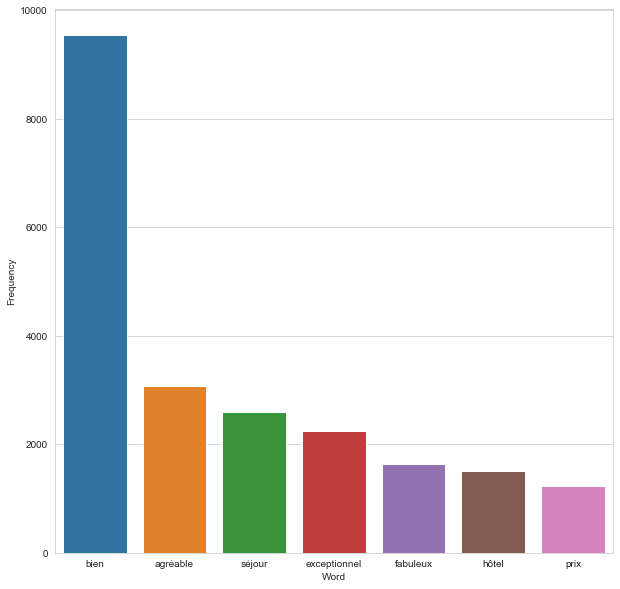

In [26]:
#histogramme des 7 mots les plus fréquents
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

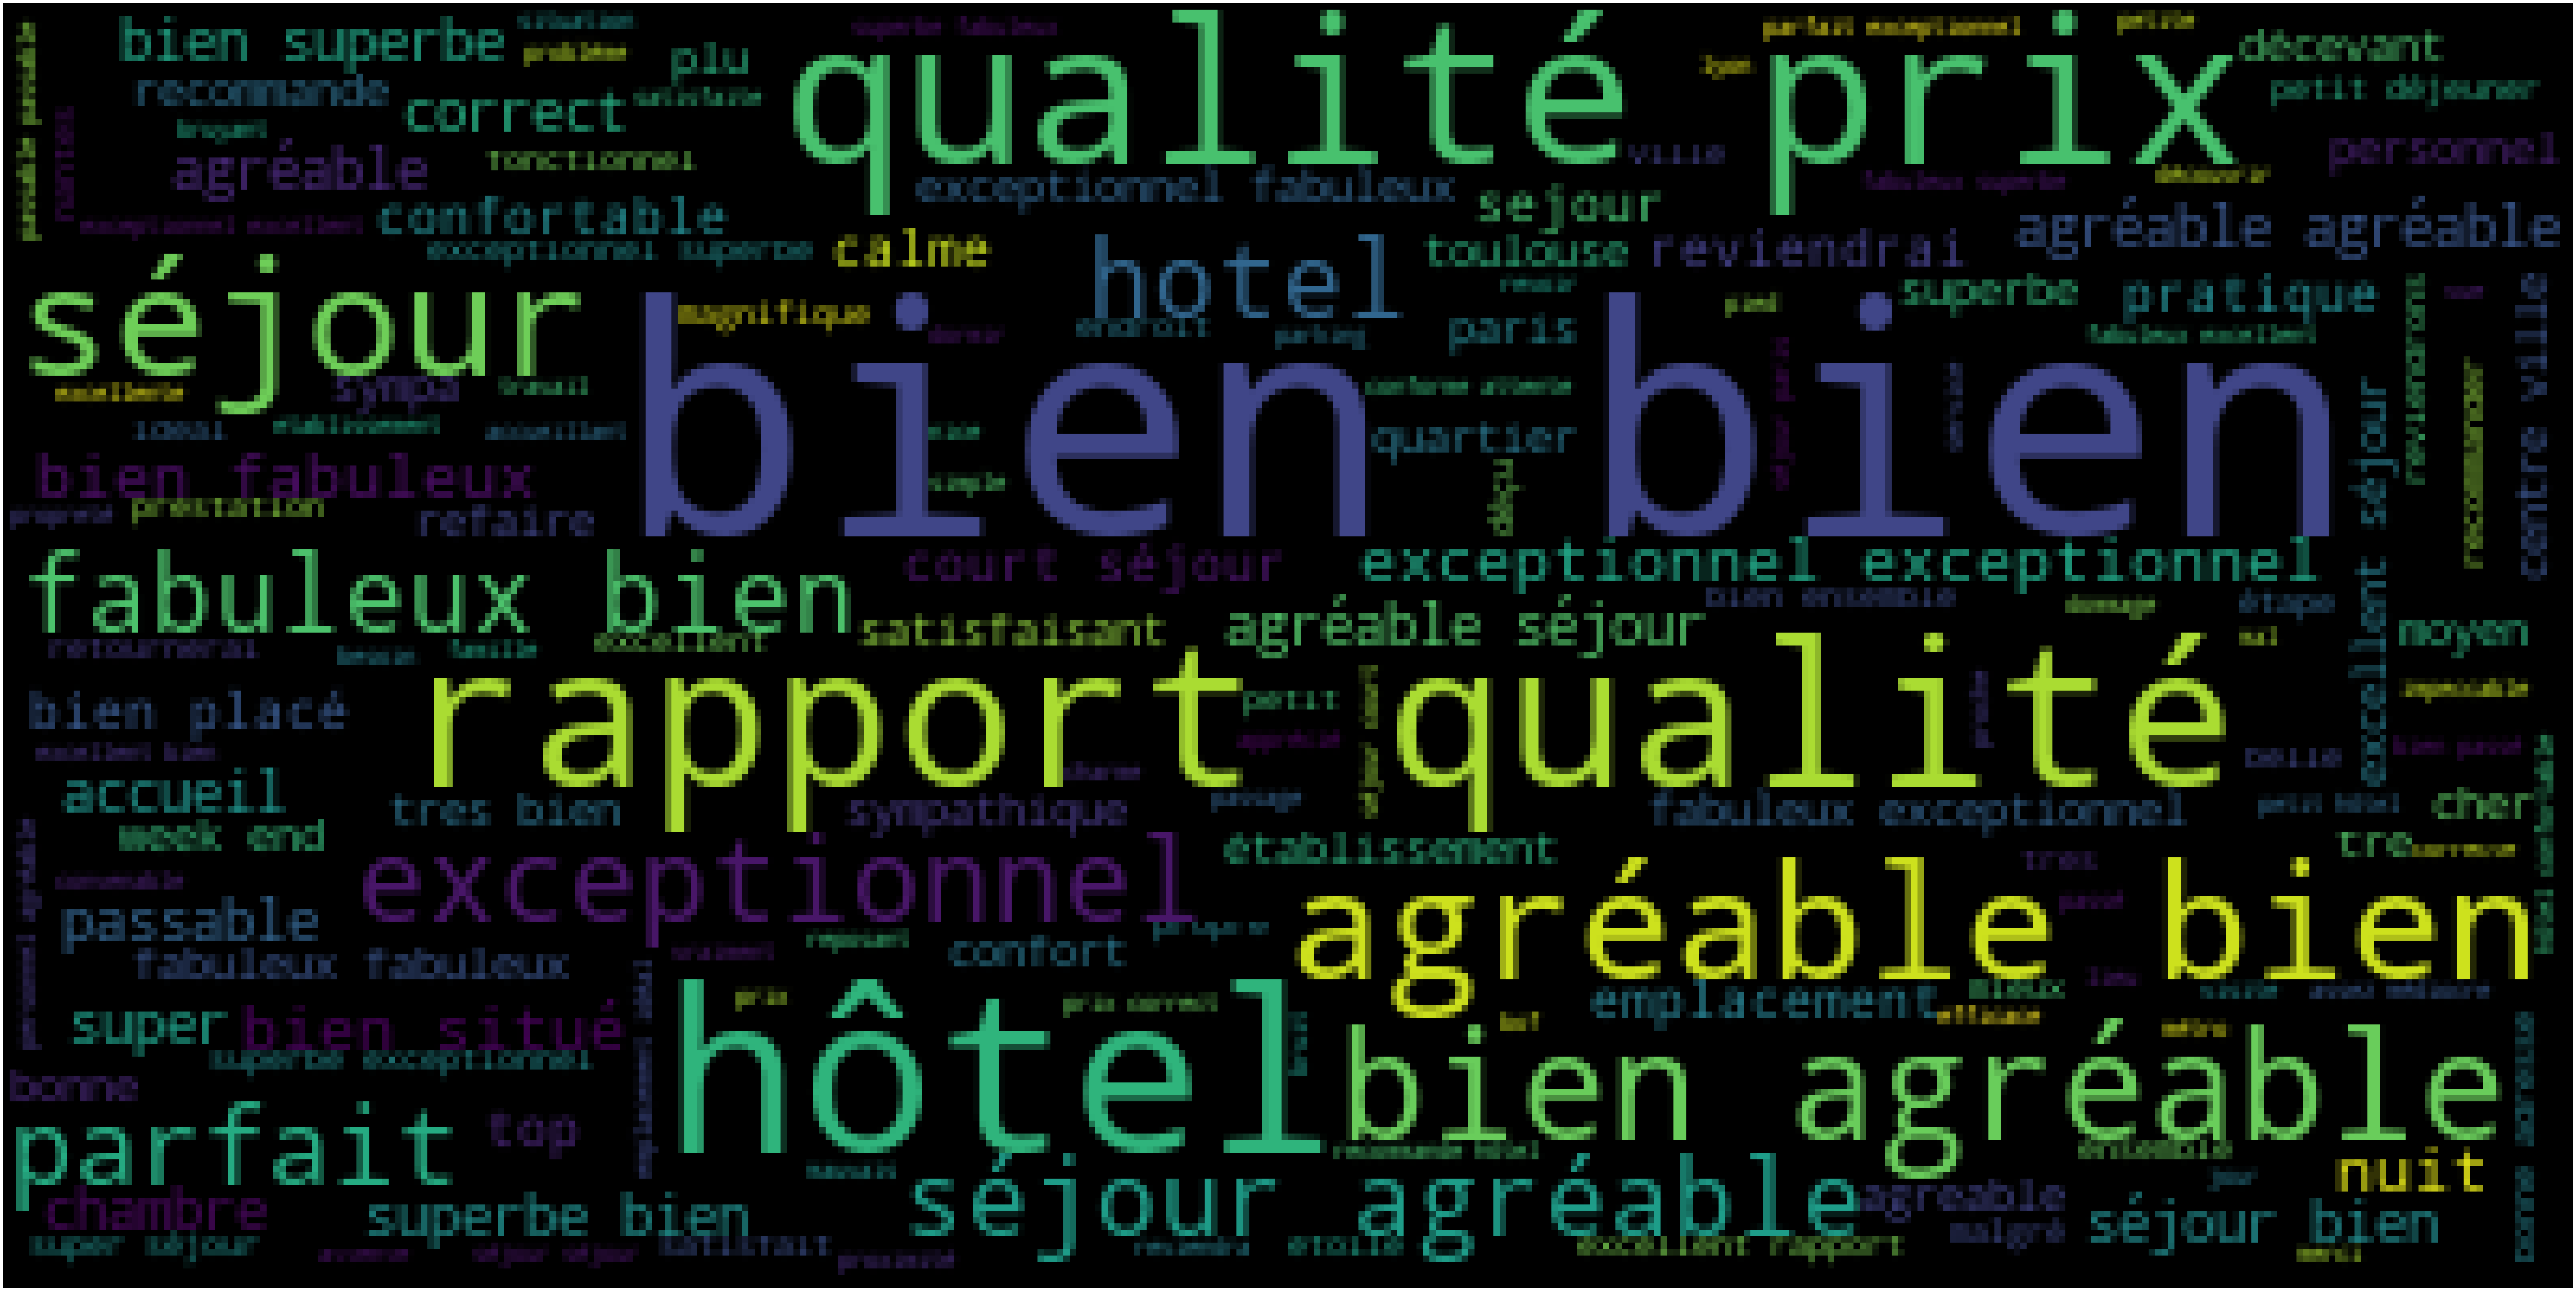

In [27]:
#nuage de mots
wcloud(cleaned_data,'black','Common Words')

In [28]:
#mettre tous les éléments en miniscule, séparés par un espace
a = df['bons_points'].str.lower().str.cat(sep=' ')

#supprimer ponctuation, nombres and retourner une liste de mots
b = re.sub('[^a-zàâéèêëïîôùûç]+', ' ', a)

#supprimer tous les mots "vides" du texte
stop_words = list(get_stop_words('french'))         
nltk_words = list(stopwords.words('french'))   
stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

#supprimer les mots qui ont une longueur inférieure à 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

In [29]:
#supprimer les caractères numériques
cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

#calculer les 100 mots les plus fréquents
top_N = 100
word_dist = nltk.FreqDist(cleaned_data)
rslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])

In [30]:
#affichage dans un dataframe des 7 mots les plus fréquents
rslt.head(7)

,Word,Frequency
0,personnel,7096
1,petit,6657
2,chambre,6587
3,déjeuner,5299
4,bien,5126
5,accueil,4875
6,emplacement,4508


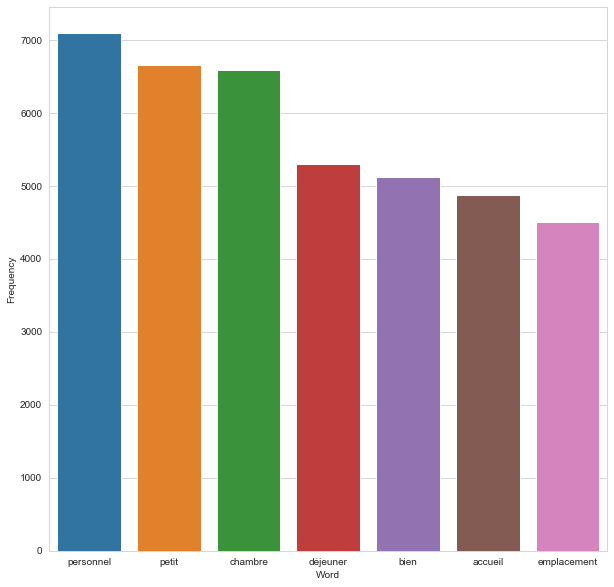

In [31]:
#histogramme des 7 mots les plus fréquents
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

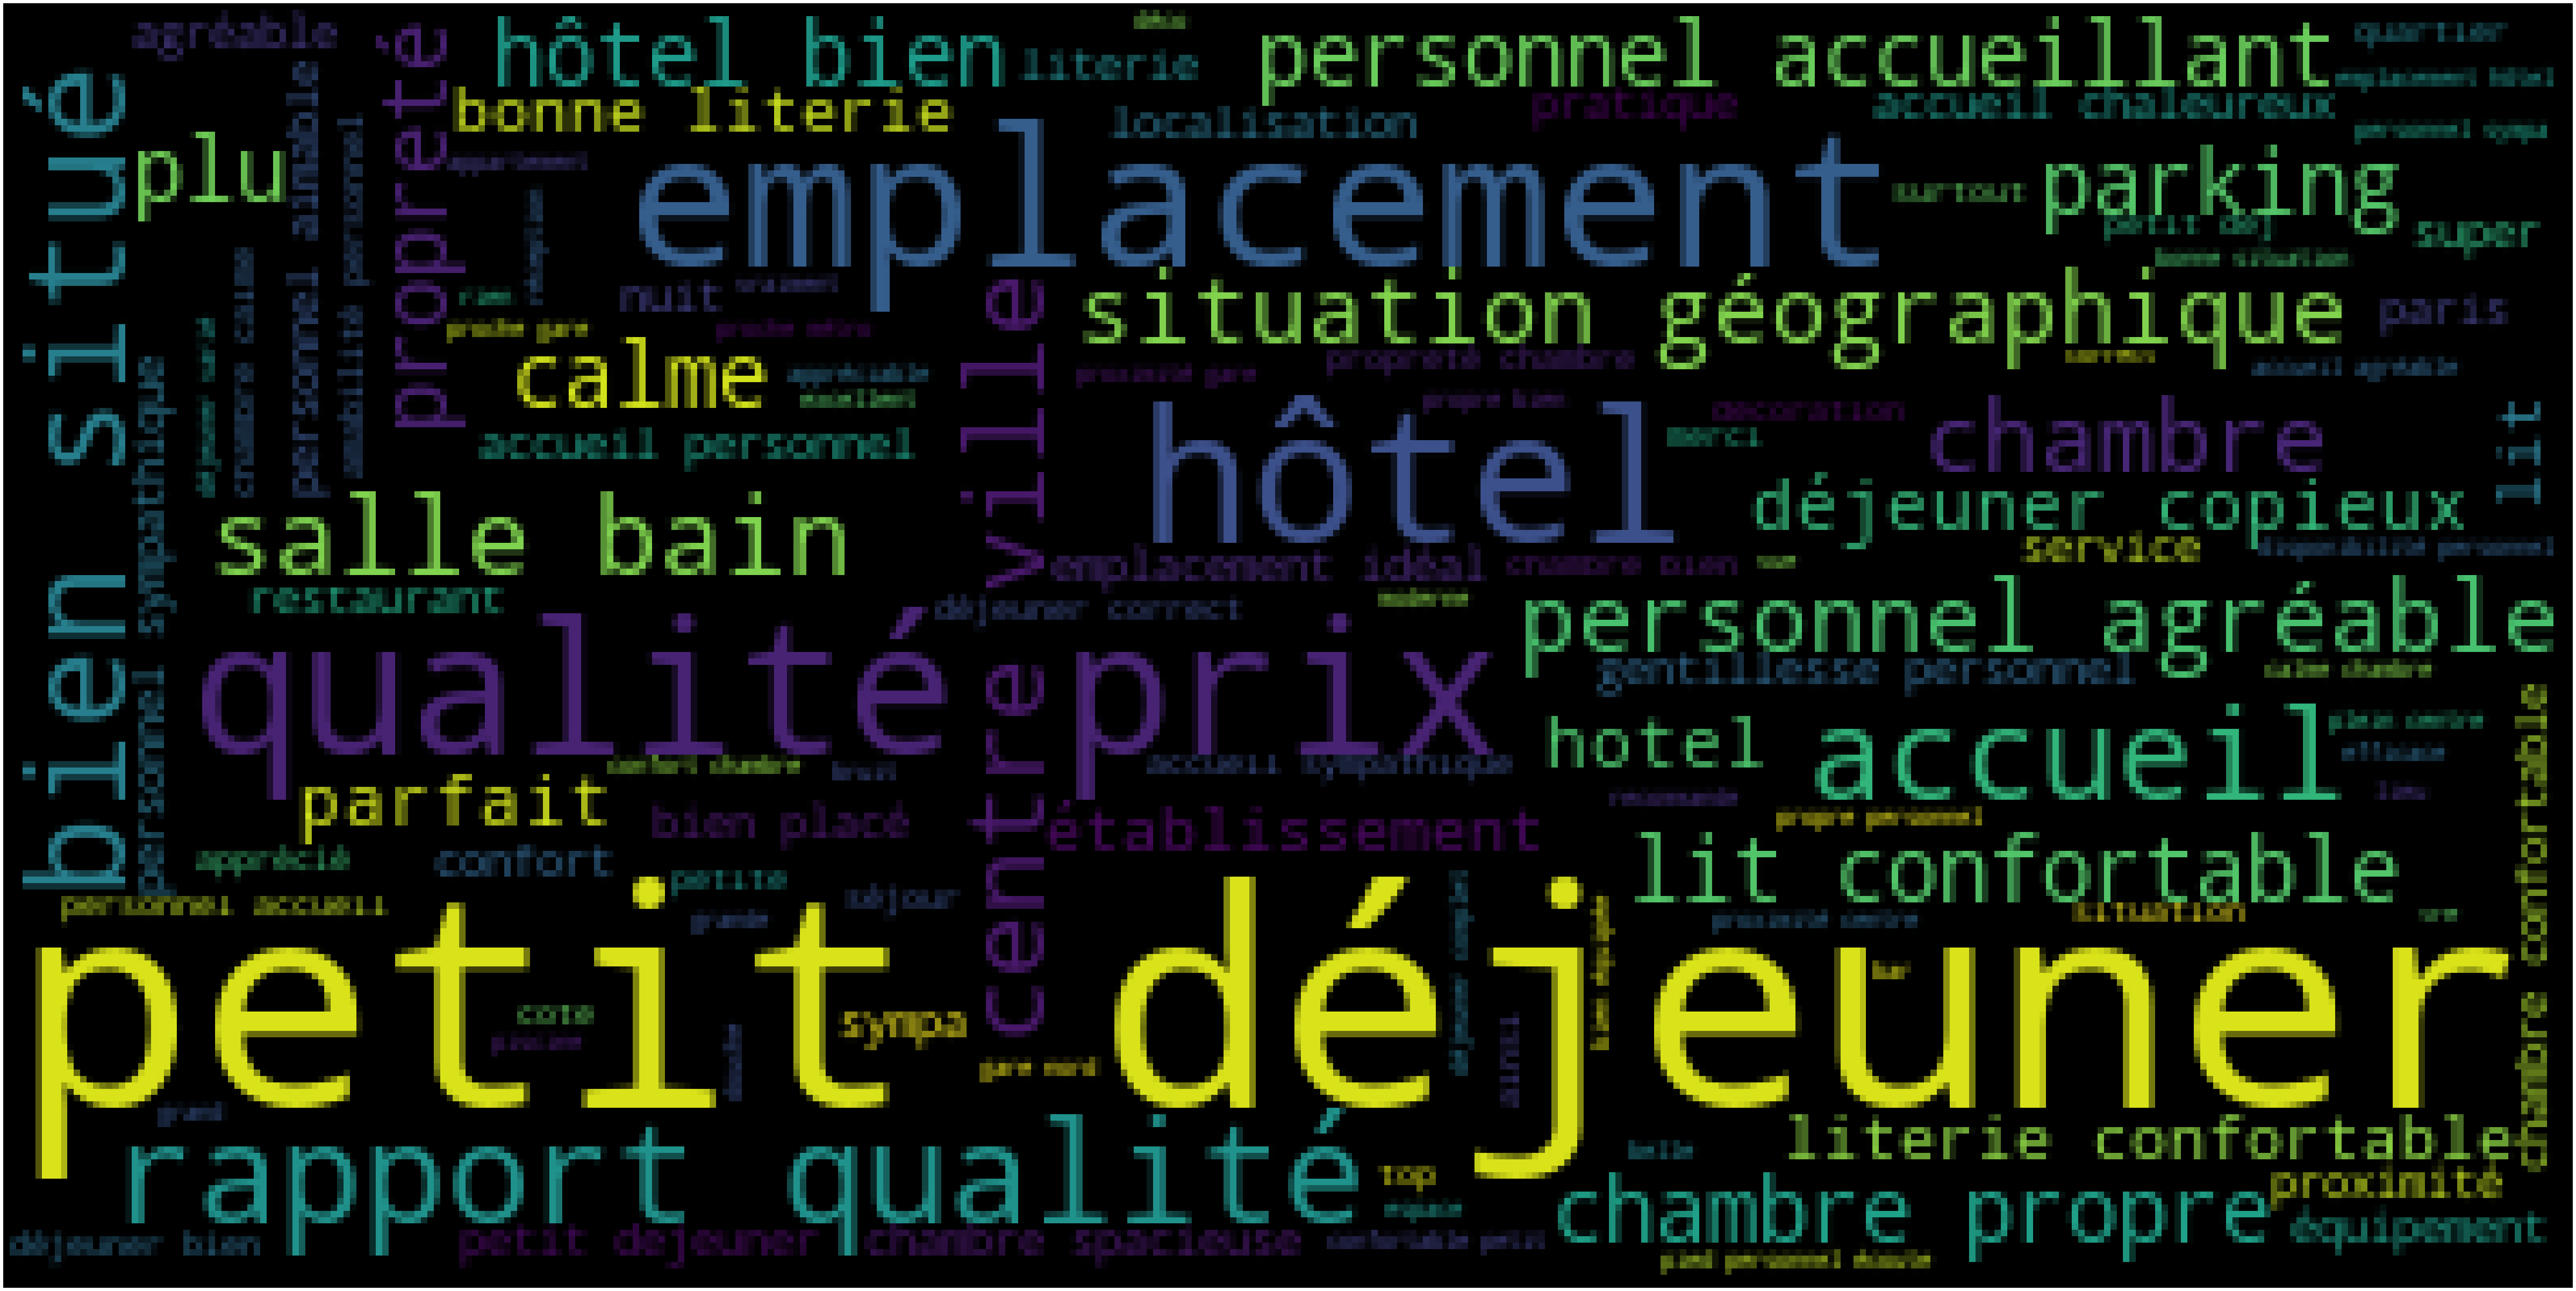

In [32]:
#nuage de mots
wcloud(cleaned_data,'black','Common Words')

In [33]:
#mettre tous les éléments en miniscule, séparés par un espace
a = df['mauvais_points'].str.lower().str.cat(sep=' ')

#supprimer ponctuation, nombres and retourner une liste de mots
b = re.sub('[^A-Za-zàâéèêëïîôùûç]+', ' ', a)

#supprimer tous les mots "vides" du texte
stop_words = list(get_stop_words('french'))         
nltk_words = list(stopwords.words('french'))   
stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

#supprimer les mots qui ont une longueur inférieure à 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

#supprimer caractères numériques
cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

In [34]:
#supprimer caractères numériques
cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

#calculer les 100 mots les plus fréquents
top_N = 100
word_dist = nltk.FreqDist(cleaned_data)
rslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])

In [35]:
#affichage dans un dataframe des 7 mots les plus fréquents
rslt.head(7)

,Word,Frequency
0,chambre,6337
1,petit,3380
2,salle,3138
3,déjeuner,2309
4,bain,2243
5,douche,2047
6,rien,1998


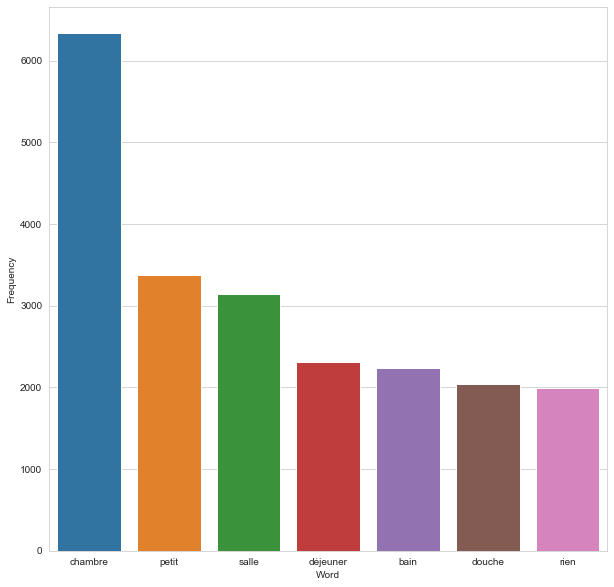

In [36]:
#histogramme des 7 mots les plus fréquents
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

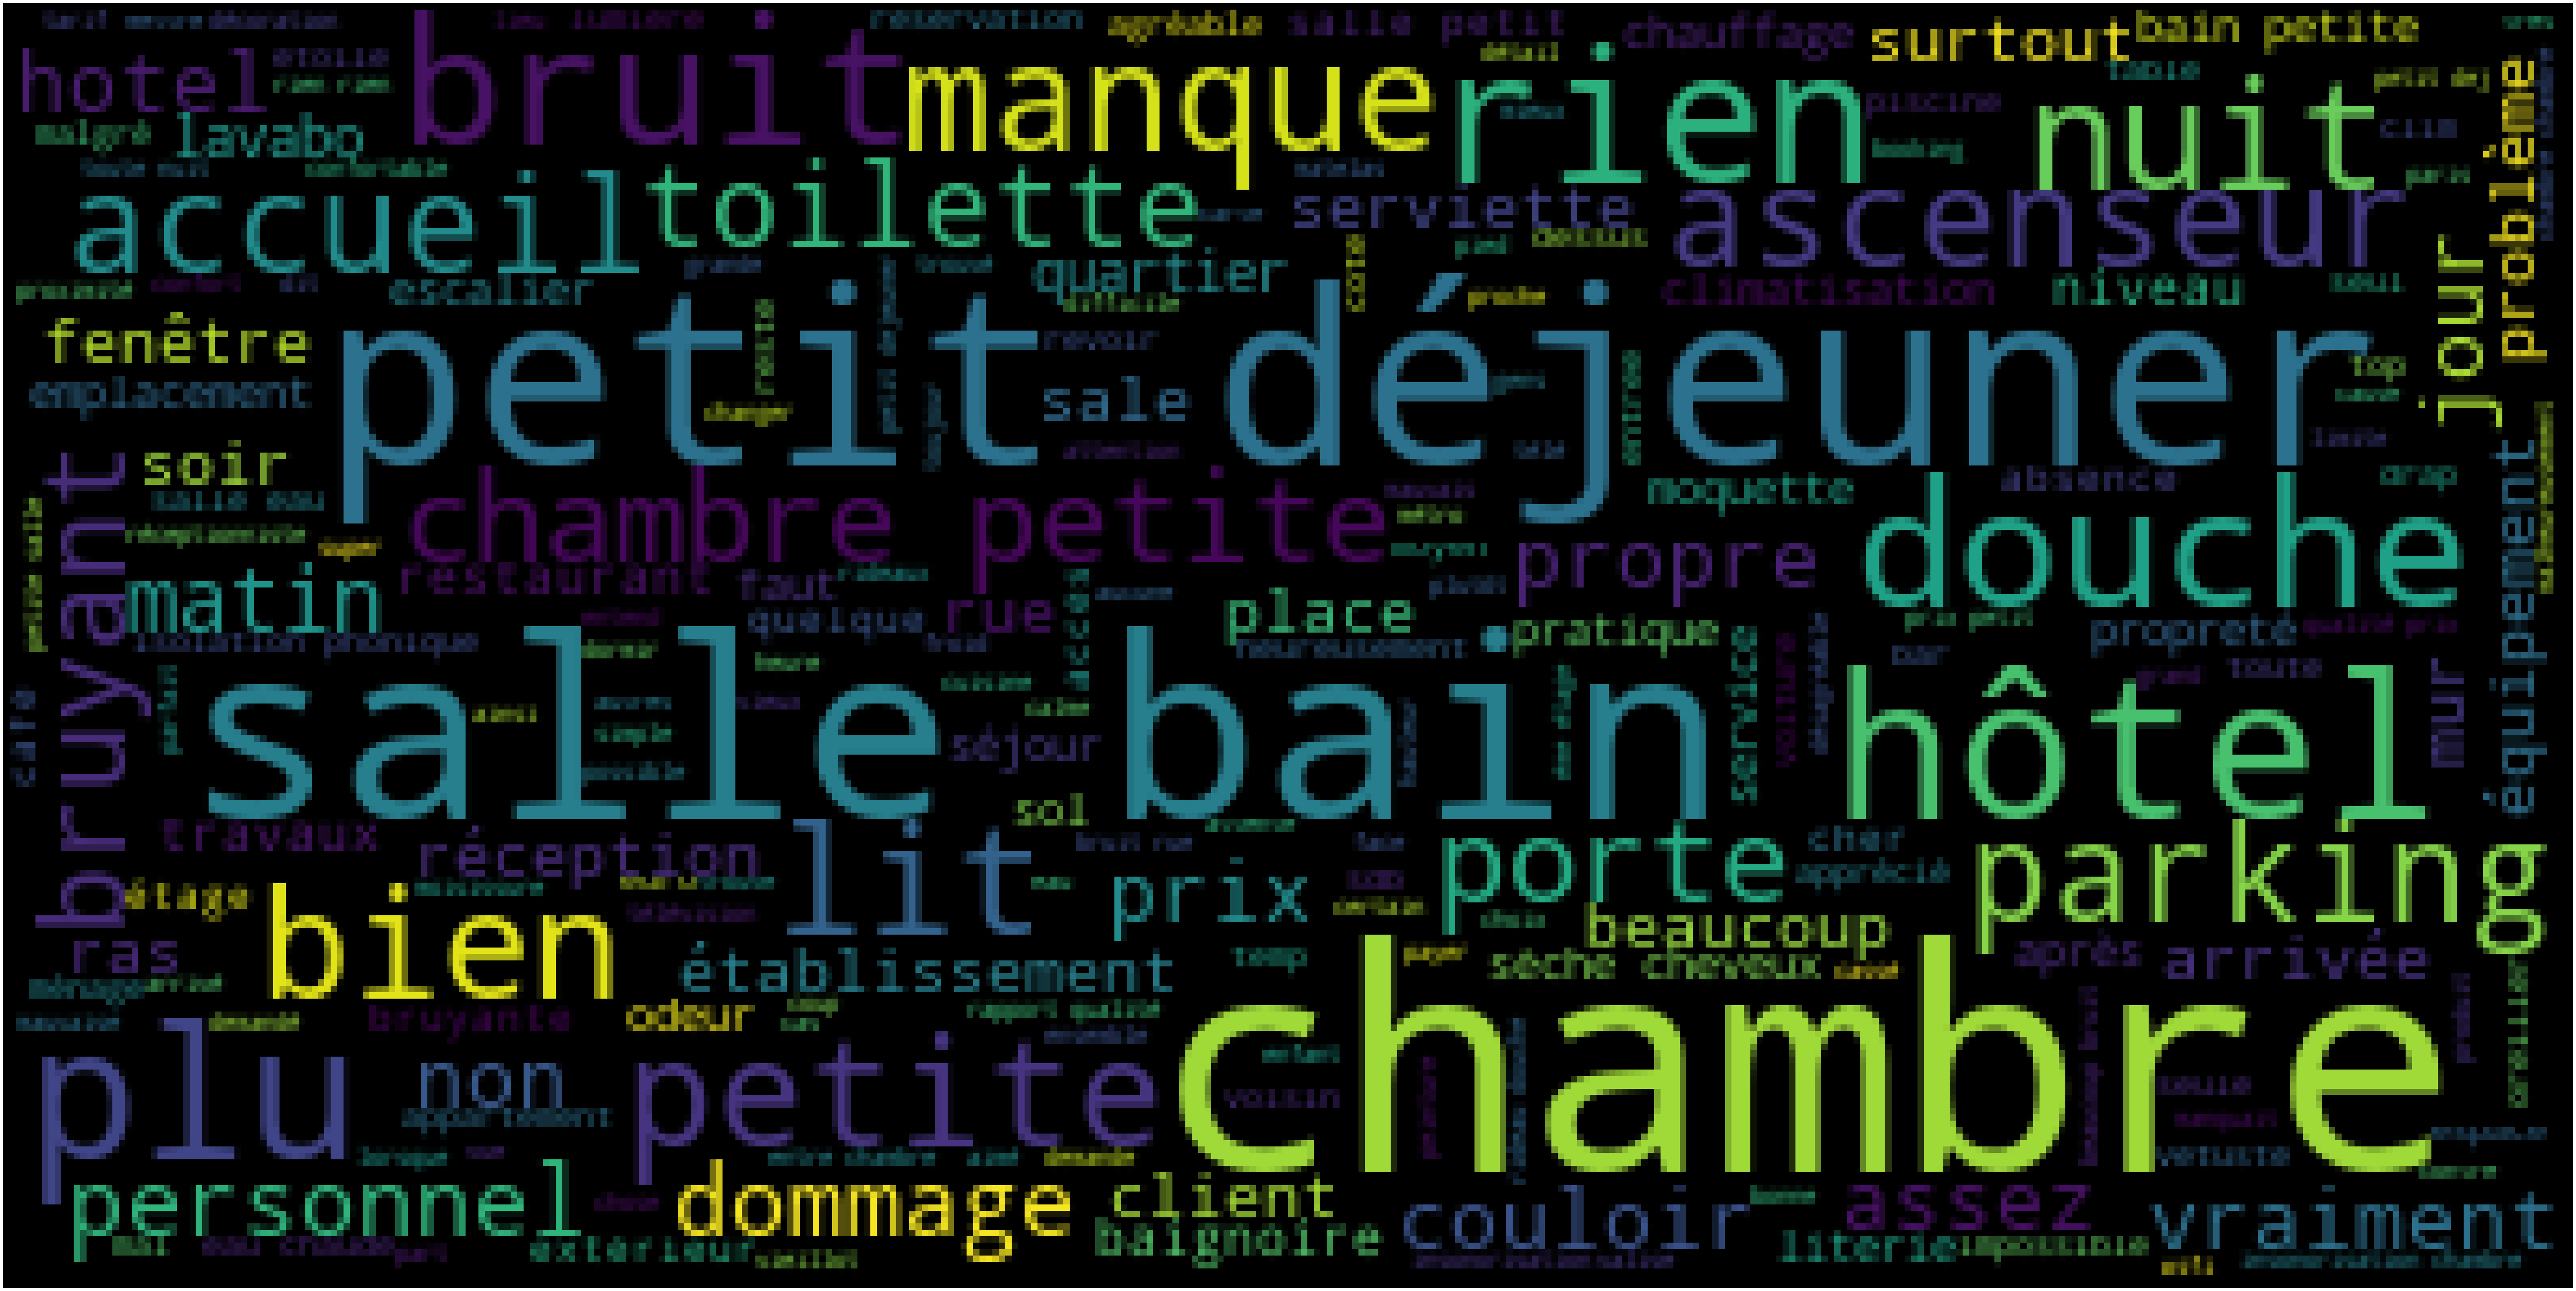

In [37]:
#nuage de mots
wcloud(cleaned_data,'black','Common Words')

In [38]:
#vérification que les NaN dans la colonne 'mauvais points' ont bien de façon certaine une polarité de zéro pour TextBlob, 
#sentiment[0]=polarite et sentiment[1]=subjectivité
#text = u"NaN"
#blob = TextBlob(text, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
#blob.sentiment
#print('NaN a une polarité de {} et une subjectivité de {}.'.format(blob.sentiment[0], blob.sentiment[1]))

In [39]:
#suppression des Nan
#df = df.fillna('')
#suppression de deux phrases récurrentes dans les données
#df = df[df.bons_points != "Ce commentaire n'apparaît pas car il ne respecte pas notre charte."]
#df = df[df.bons_points != "Ce client n'a pas laissé de commentaire."]

#df = df[df.mauvais_points != "Ce commentaire n'apparaît pas car il ne respecte pas notre charte."]
#df = df[df.mauvais_points != "Ce client n'a pas laissé de commentaire."]

In [40]:
#suppression de deux phrases récurrentes dans les données
#df = df[df.bons_points != "Ce commentaire n'apparaît pas car il ne respecte pas notre charte."]
#df = df[df.bons_points != "Ce client n'a pas laissé de commentaire."]

#df = df[df.mauvais_points != "Ce commentaire n'apparaît pas car il ne respecte pas notre charte."]
#df = df[df.mauvais_points != "Ce client n'a pas laissé de commentaire."]

In [41]:
#concaténation 
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
df22 = pd.DataFrame(df, columns= ['bons_points', 'mauvais_points'])

df23=df22['bons_points']
df24=df22['mauvais_points']

In [42]:
df23=pd.DataFrame(data=df23)
#df23['polarite']=1
df23.head()

,bons_points
0,"Établissement recent, propre, soigne, chouette..."
1,"Accueil très chaleureux, chambre calme...tout ..."
2,Tout bié sauf le wifi catastrophiquement lent!...
3,
4,Excellent rapport qualité prix. Personnel très...


In [43]:
df24=pd.DataFrame(data=df24)
#df24['polarité']=0
df24.columns = ['bons_points']
df24.head()

,bons_points
0,Rien
1,
2,
3,Hôtel parfait. Quartier sympa.
4,


In [44]:
frames = [df23, df24]
result = pd.concat(frames)
result

,bons_points
0,"Établissement recent, propre, soigne, chouette..."
1,"Accueil très chaleureux, chambre calme...tout ..."
2,Tout bié sauf le wifi catastrophiquement lent!...
3,
4,Excellent rapport qualité prix. Personnel très...
...,...
30941,C'est regrettable de ne pas avoir de plateau d...
30942,Rien tout étais au top! Merci!
30943,Rien
30944,


In [45]:
df21 = result['bons_points']
df21 = pd.DataFrame(df21, columns=['bons_points'])

In [46]:
df21.head()

,bons_points
0,"Établissement recent, propre, soigne, chouette..."
1,"Accueil très chaleureux, chambre calme...tout ..."
2,Tout bié sauf le wifi catastrophiquement lent!...
3,
4,Excellent rapport qualité prix. Personnel très...


In [47]:
df21.columns=['sentences']

In [48]:
#mettre les commentaires du dataframe en miniscule
df21['sentences']=df21['sentences'].str.lower()
df21.head()

,sentences
0,"établissement recent, propre, soigne, chouette..."
1,"accueil très chaleureux, chambre calme...tout ..."
2,tout bié sauf le wifi catastrophiquement lent!...
3,
4,excellent rapport qualité prix. personnel très...


In [49]:
df21.shape

(58844, 1)

In [50]:
#remplacement de tout ce qui n'est pas dans le set[] par un espace
df21['sentences'] = df21['sentences'].apply(lambda x: re.sub('[^a-zàâéèêëïîôùûçæœ-]+',' ', str(x))) 
#for index, row in df21.iterrows():
    #print('index: ', index, 'col sentences:', row['sentences'])

In [51]:
from nltk.corpus import stopwords
stop = stopwords.words('french')

In [52]:
#suppression des mots "vides" dans le dataframe
df21['sentences'] = df21['sentences'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#for index, row in df21.iterrows():
    #print('index: ', index, 'col sentences:', row['sentences'])

In [53]:
#suppression des mots d'une longueur inférieure à 2 caractères
#\b=la fin et le début d'un mot
#`r' ou`R': préfixe pour les chaines de caractère 
df21['sentences']=df21.sentences.str.replace(r'\b(\w{1,2})\b', '')
#for index, row in df21.iterrows():
    #print('index: ', index, 'col sentences:', row['sentences'])

In [54]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='french')

def return_stem(sentence):
    doc = nlp(sentence)
    return [stemmer.stem(X.text) for X in doc]

In [55]:
df22=df21.copy()

In [56]:
type(df22)

pandas.core.frame.DataFrame

In [57]:
df22.head()

,sentences
0,établissement recent propre soigne chouette de...
1,accueil très chaleureux chambre calme tout pas...
2,tout bié sauf wifi catastrophiquement lent meg...
3,
4,excellent rapport qualité prix personnel très ...


In [58]:
#Existe-t-il des variables numériques?
df21['sentences'].apply(lambda x: not any(i.isnumeric() for i in x.split())).any()

False

In [59]:
df21['sentences'].str.contains(r'[0-9]').any()

False

In [60]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [61]:
#récupération des commentaires dans le type series
df21 = df21['sentences']
type(df21)

pandas.core.series.Series

In [62]:
#calcul de la polarité des commentaires avec TextBlob
bloblist_desc = list()

df_str=df21.astype(str)
for row in df_str:
    blob = TextBlob(row)
    #print(blob)
    pos_tagger=PatternTagger()
    analyzer=PatternAnalyzer()
    blob = tb(str(blob)) #textblob
    #sentiment renvoie un tuple avec la polarité et la subjectivite
    #print(blob.sentiment[0])
    #type(blob.sentiment[0])
    bloblist_desc.append(blob.sentiment[0])
    #df_polarity_desc1 = pd.DataFrame(bloblist_desc, columns = ['sentiment'])

In [63]:
#récupération des résultats de la polarité dans un dataframe
df_polarity_desc1 = pd.DataFrame(data = bloblist_desc)
df_polarity_desc1.columns = ['sentiment']
df_polarity_desc1.head()

,sentiment
0,0.261429
1,0.422500
2,-0.066667
3,0.000000
4,0.487500


In [64]:
#classification des commentaires selon trois modalités (neutres, positifs et négatifs) dans un dataframe
def f(df_polarity_desc1):
    if df_polarity_desc1['sentiment'] > 0:
        val = "positive"
    elif df_polarity_desc1['sentiment'] < 0:
        val = "negative"
    else :
        val = "neutre"
    return val

df_polarity_desc1.apply(f, axis=1)
df_polarity_desc1['polarite']=df_polarity_desc1.apply(f, axis=1)

In [65]:
df_polarity_desc1.head()

,sentiment,polarite
0,0.261429,positive
1,0.422500,positive
2,-0.066667,negative
3,0.000000,neutre
4,0.487500,positive


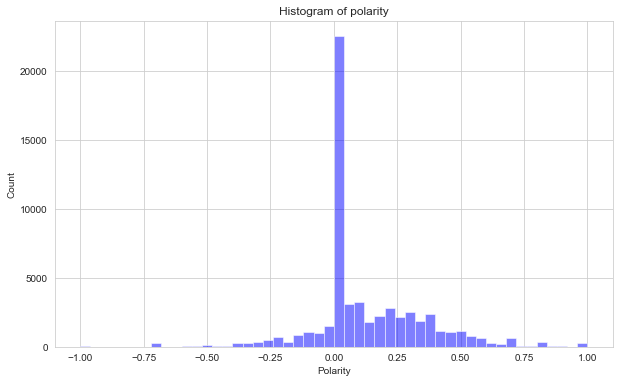

In [66]:
#fonction de masse de la polarité des commentaires
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df_polarity_desc1.sentiment, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of polarity')
plt.show();

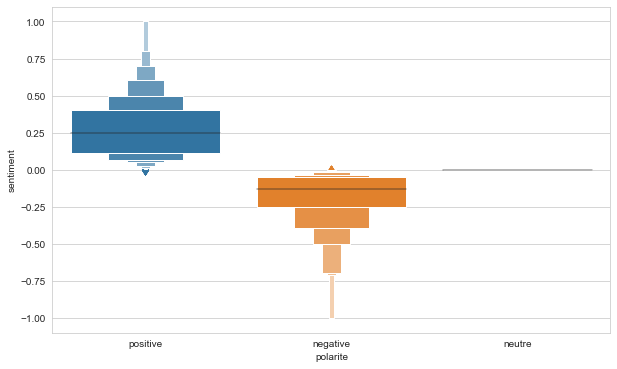

In [67]:
#boxenplot de la polarité des commenatires, boxplot avec plus de quartiles
plt.figure(figsize=(10,6))
sns.boxenplot(x='polarite', y='sentiment', data=df_polarity_desc1)
plt.show();

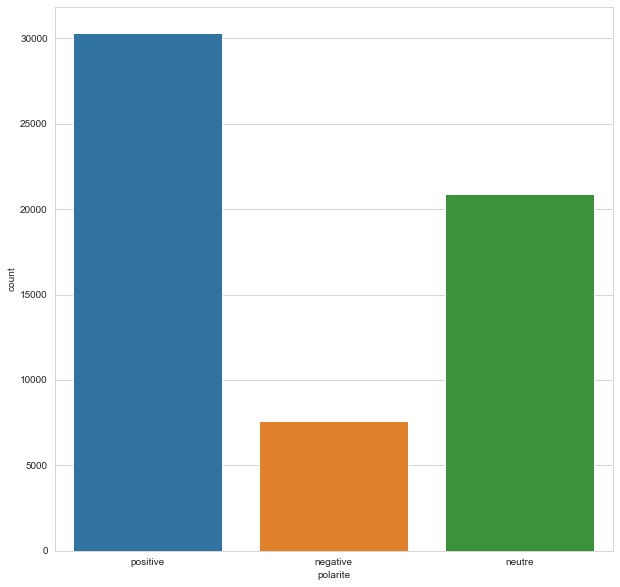

In [68]:
#countplot des modalités correspondant à la polarité des commentaires
df_polarity_desc1.head()
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="polarite", data=df_polarity_desc1)

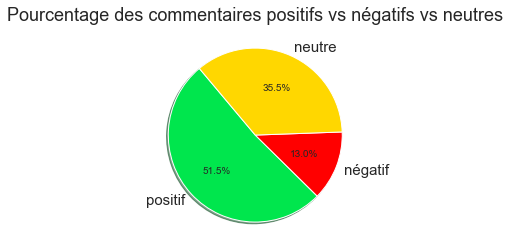

In [70]:
#diagramme circulaire des modalités de la polarité des commentaires
pourcentage_positive = round(len(df_polarity_desc1.loc[(df_polarity_desc1.polarite == "positive")])) / len(df_polarity_desc1)
pourcentage_negative = round(len(df_polarity_desc1.loc[(df_polarity_desc1.polarite == "negative")])) / len(df_polarity_desc1)
pourcentage_neutre = round(len(df_polarity_desc1.loc[(df_polarity_desc1.polarite == "neutre")])) / len(df_polarity_desc1)

fig1, ax1 = plt.subplots()

plt.title("Pourcentage des commentaires positifs vs négatifs vs neutres", fontsize=18)
labels = ['positif', 'négatif', 'neutre']
sizes = [pourcentage_positive, pourcentage_negative, pourcentage_neutre]
#explode = (0, 0.2)  # seulement détacher le second groupe

patches, texts, autotexts = ax1.pie(sizes,  labels=labels, autopct='%1.1f%%', shadow = True, startangle=130, colors = ['#00e64d', 'r', '#FFD700'])
texts[0].set_fontsize(15)
texts[1].set_fontsize(15)
texts[2].set_fontsize(15)

matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams["font.size"] = 18
plt.rcParams["figure.figsize"] = [6, 6]

In [71]:
df = pd.read_csv(r"C:\Users\utilisateur\Documents\Projet\ProjetNLP\booking.csv", na_values=['None'], decimal=',')
df23=df['note']
df24=df['note']
frames = [df23, df24]
df_notes = pd.concat(frames)
df_notes.shape

(61892,)

In [72]:
type(df_notes)

pandas.core.series.Series

In [73]:
df_polarity_desc1_polarite = df_polarity_desc1.iloc[:,1]
#df_polarity_desc1_polarite = pd.DataFrame(df_polarity_desc1_polarite)
df_polarity_desc1_polarite.head()

0    positive
1    positive
2    negative
3      neutre
4    positive
Name: polarite, dtype: object

In [74]:
df_notes.reset_index(drop=True, inplace=True)
df_polarity_desc1_polarite.reset_index(drop=True, inplace=True)
df_corr = pd.concat([df_polarity_desc1_polarite, df_notes], axis = 1)

In [75]:
df_corr.head()

,polarite,note
0,positive,10.0
1,positive,9.0
2,negative,9.6
3,neutre,10.0
4,positive,9.0


In [76]:
df_corr=df_corr.loc[(df_corr.polarite=='positive')|(df_corr.polarite=='negative')]

In [77]:
type(df_corr)

pandas.core.frame.DataFrame

In [78]:
df_corr.head()

,polarite,note
0,positive,10.0
1,positive,9.0
2,negative,9.6
4,positive,9.0
5,positive,7.9


In [79]:
df_corr['polarite'] = np.where(df_corr['polarite'] == 'positive', 1, 0)
df_corr.head()

,polarite,note
0,1,10.0
1,1,9.0
2,0,9.6
4,1,9.0
5,1,7.9


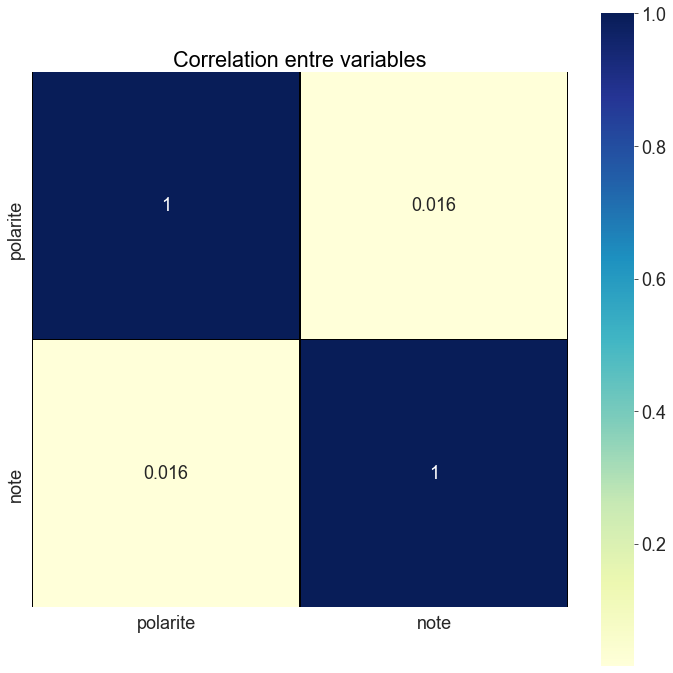

In [80]:
#affichage des corrélations entre variables
#parfaite si r = 1
#très forte si r > 0,8
#forte si r se situe entre 0,5 et 0,8
#d'intensité moyenne si r se situe entre 0,2 et 0,5
#faible si r se situe entre 0 et 0.2

f, ax = plt.subplots(figsize=(12, 12))
plt.title('Correlation entre variables')
sns.heatmap(df_corr.corr(),linewidths=0.25,vmax=1.0, square=True, cmap="YlGnBu", linecolor='black', annot=True);

In [81]:
#concaténation des trois colonnes correspondant aux commentaires sur les hôtels
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
df22 = pd.DataFrame(df, columns= ['titre', 'bons_points', 'mauvais_points'])

df21 = df22['titre'].map(str) + ' ' + df22['bons_points'].map(str) + ' ' + df22['mauvais_points'].map(str)

df21

0        Exceptionnel Établissement recent, propre, soi...
1        Fabuleux  Accueil très chaleureux, chambre cal...
2        Exceptionnel Tout bié sauf le wifi catastrophi...
3          Exceptionnel nan Hôtel parfait. Quartier sympa.
4        Fabuleux  Excellent rapport qualité prix. Pers...
                               ...                        
30941    Exceptionnel L'hôtel est agréable et confortab...
30942    Exceptionnel La chambre, le personnel au top e...
30943    Hôtel très confortable La chambre, ses équipem...
30944         Déjà utilisé plusieurs fois Salle claire nan
30945           Bien  La situation face à la gare Le bruit
Length: 30946, dtype: object

In [82]:
#convertir series en dataframe
df21 = df21.to_frame(name="sentences")

In [83]:
#mettre les commentaires du dataframe en miniscule
df21['sentences']=df21['sentences'].str.lower()
df21.head()

,sentences
0,"exceptionnel établissement recent, propre, soi..."
1,"fabuleux accueil très chaleureux, chambre cal..."
2,exceptionnel tout bié sauf le wifi catastrophi...
3,exceptionnel nan hôtel parfait. quartier sympa.
4,fabuleux excellent rapport qualité prix. pers...


In [84]:
#remplacement de tout ce qui n'est pas dans le set[] par un espace
df21['sentences'] = df21['sentences'].apply(lambda x: re.sub('[^a-zàâéèêëïîôùûçæœ-]+',' ', str(x))) 
#for index, row in df21.iterrows():
    #print('index: ', index, 'col sentences:', row['sentences'])

In [85]:
#suppression des mots "vides" dans le dataframe
stop = stopwords.words('french')
df21['sentences'] = df21['sentences'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#for index, row in df21.iterrows():
    #print('index: ', index, 'col sentences:', row['sentences'])

In [86]:
#suppression des mots d'une longueur inférieure à 2 caractères
#\b=la fin et le début d'un mot
#`r' ou`R': préfixe pour les chaines de caractère 
df21['sentences']=df21.sentences.str.replace(r'\b(\w{1,2})\b', '')
#for index, row in df21.iterrows():
    #print('index: ', index, 'col sentences:', row['sentences'])

In [87]:
df22=df21.copy()

In [88]:
type(df22)

pandas.core.frame.DataFrame

In [89]:
df22.head()

,sentences
0,exceptionnel établissement recent propre soign...
1,fabuleux accueil très chaleureux chambre calme...
2,exceptionnel tout bié sauf wifi catastrophique...
3,exceptionnel nan hôtel parfait quartier sympa
4,fabuleux excellent rapport qualité prix person...


In [90]:
#Existe-t-il des variables numériques?
df21['sentences'].apply(lambda x: not any(i.isnumeric() for i in x.split())).any()

False

In [91]:
#récupération des commentaires dans le type series
df21 = df21['sentences']
type(df21)

pandas.core.series.Series

In [92]:
#calcul de la polarité des commentaires avec TextBlob
bloblist_desc = list()

df_str=df21.astype(str)
for row in df_str:
    blob = TextBlob(row)
    #print(blob)
    pos_tagger=PatternTagger()
    analyzer=PatternAnalyzer()
    blob = tb(str(blob)) #textblob
    #sentiment renvoie un tuple avec la polarité et la subjectivite
    #print(blob.sentiment[0])
    #type(blob.sentiment[0])
    bloblist_desc.append(blob.sentiment[0])
    #df_polarity_desc1 = pd.DataFrame(bloblist_desc, columns = ['sentiment'])

In [93]:
#récupération des résultats de la polarité dans un dataframe
df_polarity_desc1 = pd.DataFrame(data = bloblist_desc)
df_polarity_desc1.columns = ['sentiment']
df_polarity_desc1.head()

,sentiment
0,2.537500e-01
1,5.380000e-01
2,1.387779e-17
3,4.000000e-01
4,5.900000e-01


In [94]:
#classification des commentaires selon trois modalités (neutres, positifs et négatifs) dans un dataframe
def f(df_polarity_desc1):
    if df_polarity_desc1['sentiment'] > 0:
        val = "positive"
    elif df_polarity_desc1['sentiment'] < 0:
        val = "negative"
    else :
        val = "neutre"
    return val

df_polarity_desc1.apply(f, axis=1)
df_polarity_desc1['polarite']=df_polarity_desc1.apply(f, axis=1)

In [95]:
#sélection de la colonne notes 
df = pd.read_csv(r"C:\Users\utilisateur\Documents\Projet\ProjetNLP\booking.csv", na_values=['None'], decimal=',')
df_notes = df.iloc[:,7]
#df_notes = pd.DataFrame(data=df_notes)
df_notes.head()

0    10.0
1     9.0
2     9.6
3    10.0
4     9.0
Name: note, dtype: float64

In [96]:
#sélection de la colonne polarite
df_polarity_desc1_polarite = df_polarity_desc1.iloc[:,1]
#df_polarity_desc1_polarite = pd.DataFrame(df_polarity_desc1_polarite)
df_polarity_desc1_polarite.head()

0    positive
1    positive
2    positive
3    positive
4    positive
Name: polarite, dtype: object

In [97]:
#concaténation de la colonne notes et polarite
df_corr = pd.concat([df_polarity_desc1_polarite, df_notes], axis = 1)

In [98]:
#sélection des modalités postives ou négatives
df_corr=df_corr.loc[(df_corr.polarite=='positive')|(df_corr.polarite=='negative')]

In [99]:
#transformation des valeurs de la polarite en code binaire 0 et 1
df_corr['polarite'] = np.where(df_corr['polarite'] == 'positive', 1, 0)
df_corr.head()

,polarite,note
0,1,10.0
1,1,9.0
2,1,9.6
3,1,10.0
4,1,9.0


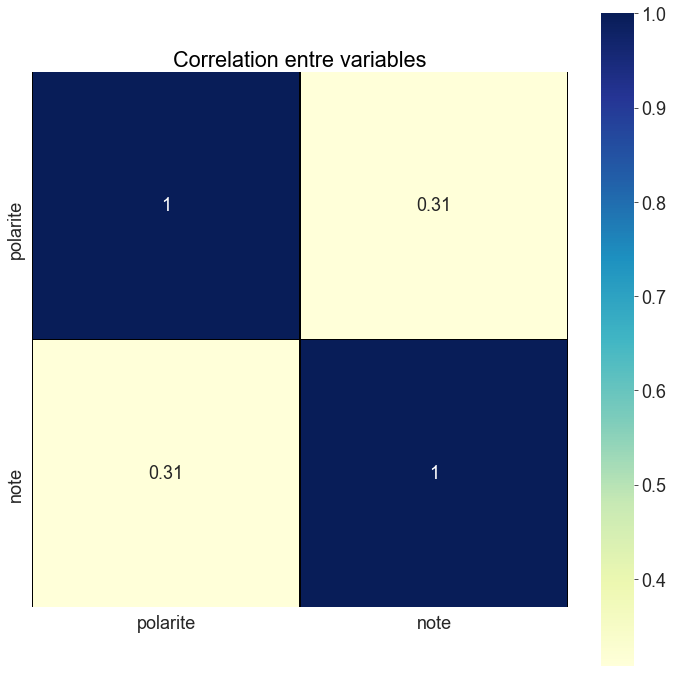

In [100]:
#affichage des corrélations entre variables
#parfaite si r = 1
#très forte si r > 0,8
#forte si r se situe entre 0,5 et 0,8
#d'intensité moyenne si r se situe entre 0,2 et 0,5
#faible si r se situe entre 0 et 0.2

f, ax = plt.subplots(figsize=(12, 12))
plt.title('Correlation entre variables')
sns.heatmap(df_corr.corr(),linewidths=0.25,vmax=1.0, square=True, cmap="YlGnBu", linecolor='black', annot=True);

In [101]:
#df_polarity_desc1.head()

,sentiment,polarite
0,2.537500e-01,positive
1,5.380000e-01,positive
2,1.387779e-17,positive
3,4.000000e-01,positive
4,5.900000e-01,positive


In [102]:
#df_polarity_desc1.columns

Index(['sentiment', 'polarite'], dtype='object')

In [103]:
#Transformation des valeurs de la variable polarite en 1 et 0
#pas besoin d'utiliser le module scikit-learn car on peut le faire directement 
df_polarity_desc1['polarite'] = np.where(df_polarity_desc1['polarite'] == 'positive', 1, 0)
df_polarity_desc1 = df_polarity_desc1.reset_index(drop=True)
df_polarity_desc1.head()

,sentiment,polarite
0,2.537500e-01,1
1,5.380000e-01,1
2,1.387779e-17,1
3,4.000000e-01,1
4,5.900000e-01,1


In [104]:
#supression de la colonne sentiment
df_polarity_desc1.drop(['sentiment'],1,inplace=True)
df_polarity_desc1.head()

,polarite
0,1
1,1
2,1
3,1
4,1


In [105]:
#création d'un dataframe comments avec la colonne sentences
df21.head()
comments = pd.DataFrame(data=df21)
comments.columns = ['sentences']
comments.head()
comments.shape
type(comments)

pandas.core.frame.DataFrame

In [106]:
#df_polarity_desc1.shape
#type(df_polarity_desc1)

pandas.core.frame.DataFrame

In [107]:
#concaténation de la colonne sentences et la colonne polarite
dataset = pd.concat([comments, df_polarity_desc1])

In [108]:
comments.reset_index(drop=True, inplace=True)
df_polarity_desc1.reset_index(drop=True, inplace=True)
# fusion des deux datasets en un seul que l'on nommera df
df = pd.concat([df_polarity_desc1, comments], axis = 1)
#df.head(100)

In [109]:
#renommer les colonnes
df.columns=['sentiment', 'sentence']
df.head()

,sentiment,sentence
0,1,exceptionnel établissement recent propre soign...
1,1,fabuleux accueil très chaleureux chambre calme...
2,1,exceptionnel tout bié sauf wifi catastrophique...
3,1,exceptionnel nan hôtel parfait quartier sympa
4,1,fabuleux excellent rapport qualité prix person...


In [110]:
#supression des données manquantes
df.isnull().values.any()
df.isnull().sum()
df=df.dropna()

In [111]:
#vérification des données manquantes
df.isnull().sum()

sentiment    0
sentence     0
dtype: int64

In [112]:
#création d'un csv contenant le dataframe df utilisé pour le machine learning
df.to_csv('booking.csv', index=True)

<h1>3. Machine learning</h1>

In [113]:
#création jeux train et test
X_train, X_test, y_train, y_test = train_test_split(df[['sentence']], df['sentiment'])

In [114]:
#CountVectorizer de Scikit-learn est utilisé pour transformer un corpus de mots en vecteurs/occurence des mots 
#Tf signifie term-frequency tandis que tfidf signifie inverse document-frequency 
pipe = make_pipeline(CountVectorizer(), TfidfTransformer())
pipe.fit(X_train['sentence'])
feat_train = pipe.transform(X_train['sentence'])
feat_train.shape

(23209, 16041)

In [115]:
#minimum et maximum pour feat_train
feat_train.min(), feat_train.max()

(0.0, 1.0)

In [116]:
#transformer sans entrainer sur notre jeu test
feat_test = pipe.transform(X_test['sentence'])
feat_test.shape

(7737, 16041)

In [117]:
#arbre de décision
#définir les paramètres
#le paramètre max_depth est un seuil sur la profondeur maximale de l’arbre
"""L'indice de diversité de gini : probabilité pour chaque élément d'être choisi multipliée 
par la probabilité qu'il soit mal classé"""
 
param_grid = {'max_depth' : [400, 500], 
              'criterion' : ['gini', 'entropy']}
             
dtc = DecisionTreeClassifier(random_state=42)

dtc_grid = GridSearchCV(dtc, param_grid, cv=3)
 
#entrainer le modèle à partir de Grid Search
%time DTC = dtc_grid.fit(feat_train, y_train)

print(dtc_grid.best_score_.round(5))
print(dtc_grid.best_params_)

final_model = dtc_grid.best_estimator_

pred_train = final_model.predict(feat_train) 
pred_test = final_model.predict(feat_test)

Wall time: 26.9 s
0.90969
{'criterion': 'entropy', 'max_depth': 400}


In [118]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3919
           1       1.00      1.00      1.00     19290

    accuracy                           1.00     23209
   macro avg       1.00      1.00      1.00     23209
weighted avg       1.00      1.00      1.00     23209



In [119]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      1314
           1       0.95      0.95      0.95      6423

    accuracy                           0.92      7737
   macro avg       0.85      0.86      0.85      7737
weighted avg       0.92      0.92      0.92      7737



In [120]:
def MatriceConfusion(model):
    y_pred = model.predict(feat_test)
    # Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, pred_test)
    plt.matshow(cm)
    plt.title('Matrice de confusion', y=1.12)
    plt.colorbar()
    print(cm)
    plt.show()

[[1011  303]
 [ 336 6087]]


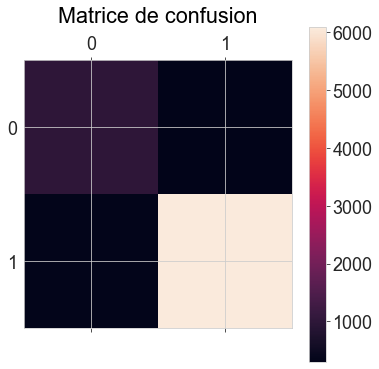

In [121]:
y_prediction = MatriceConfusion(DTC)

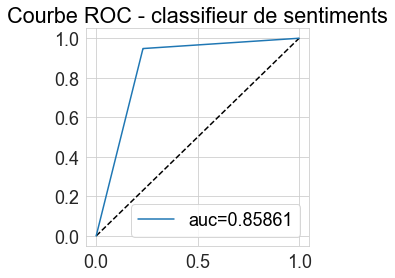

In [122]:
score = final_model.predict_proba(feat_test)
fpr, tpr, th = roc_curve(y_test, score[:, 1])
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr, tpr)
ax.plot(fpr, tpr, label='auc=%1.5f' % aucf)
ax.set_title('Courbe ROC - classifieur de sentiments')
ax.legend();

In [123]:
param_grid = {'max_depth' : [400, 500],
             'n_estimators' : [50, 70],
              'bootstrap' : [True, False],
              'criterion' : ['gini','entropy']}

rfc = RandomForestClassifier(random_state=42)

rfc_grid = GridSearchCV(rfc, param_grid, cv = 3)

%time RFC = rfc_grid.fit(feat_train, y_train)

print(rfc_grid.best_score_.round(5))
print(rfc_grid.best_params_)

final_model = rfc_grid.best_estimator_

pred_train = final_model.predict(feat_train) 
pred_test = final_model.predict(feat_test)

Wall time: 15min 44s
0.92684
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 500, 'n_estimators': 50}


In [124]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3919
           1       1.00      1.00      1.00     19290

    accuracy                           1.00     23209
   macro avg       1.00      1.00      1.00     23209
weighted avg       1.00      1.00      1.00     23209



In [125]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.94      0.64      0.76      1314
           1       0.93      0.99      0.96      6423

    accuracy                           0.93      7737
   macro avg       0.94      0.82      0.86      7737
weighted avg       0.93      0.93      0.93      7737



[[ 844  470]
 [  53 6370]]


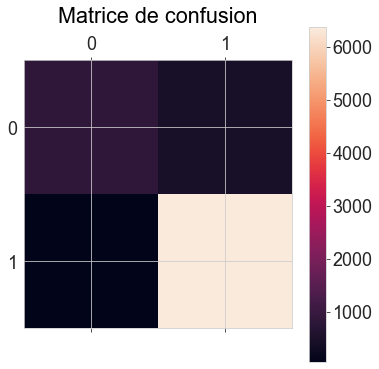

In [126]:
y_pred = MatriceConfusion(RFC)

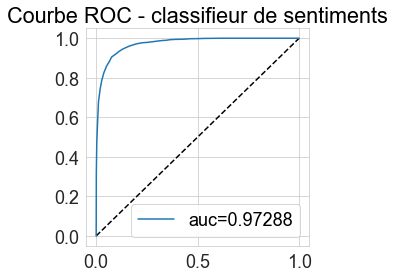

In [127]:
score = final_model.predict_proba(feat_test)
fpr, tpr, th = roc_curve(y_test, score[:, 1])
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr, tpr)
ax.plot(fpr, tpr, label='auc=%1.5f' % aucf)
ax.set_title('Courbe ROC - classifieur de sentiments')
ax.legend();

In [128]:
param_grid = {'penalty' : ['l1', 'l2']}

lr = LogisticRegression(random_state=42)

lr_grid = GridSearchCV(lr, param_grid, cv = 3)

%time LR = lr_grid.fit(feat_train, y_train)

print(lr_grid.best_score_.round(5))
print(lr_grid.best_params_)

final_model = lr_grid.best_estimator_

pred_train = final_model.predict(feat_train) 
pred_test = final_model.predict(feat_test)

Wall time: 1.33 s
0.92615
{'penalty': 'l2'}


In [129]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.97      0.75      0.85      3919
           1       0.95      1.00      0.97     19290

    accuracy                           0.95     23209
   macro avg       0.96      0.87      0.91     23209
weighted avg       0.95      0.95      0.95     23209



In [130]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.94      0.69      0.80      1314
           1       0.94      0.99      0.97      6423

    accuracy                           0.94      7737
   macro avg       0.94      0.84      0.88      7737
weighted avg       0.94      0.94      0.94      7737



[[ 907  407]
 [  54 6369]]


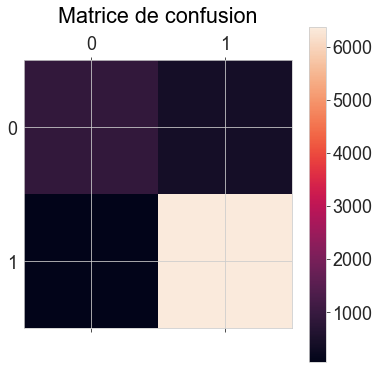

In [131]:
y_pred = MatriceConfusion(LR)

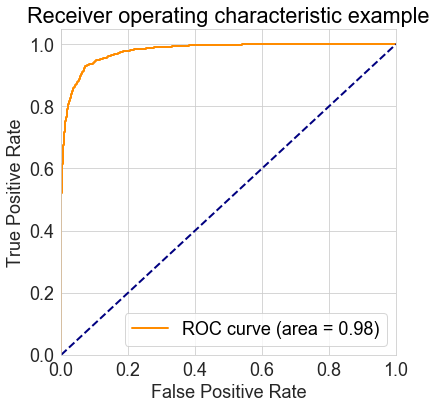

In [132]:
y_score = final_model.decision_function(feat_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [133]:
#bagging
from sklearn.ensemble import BaggingClassifier as BC
naivebayes = nb.BernoulliNB()
modelB = BC(base_estimator = naivebayes, n_estimators = 1000, warm_start = True, bootstrap_features=True, max_samples=0.9)
modelB_fit = modelB.fit(feat_train, y_train)
modelB_fit.score(feat_test,y_test)
pred_train = modelB.predict(feat_train)
pred_test = modelB.predict(feat_test)

In [134]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73      3919
           1       0.95      0.94      0.94     19290

    accuracy                           0.91     23209
   macro avg       0.83      0.84      0.84     23209
weighted avg       0.91      0.91      0.91     23209



In [135]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.71      0.65      0.67      1314
           1       0.93      0.95      0.94      6423

    accuracy                           0.89      7737
   macro avg       0.82      0.80      0.81      7737
weighted avg       0.89      0.89      0.89      7737



[[ 848  466]
 [ 352 6071]]


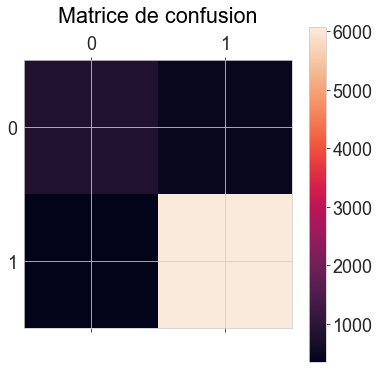

In [136]:
y_pred = MatriceConfusion(modelB_fit)

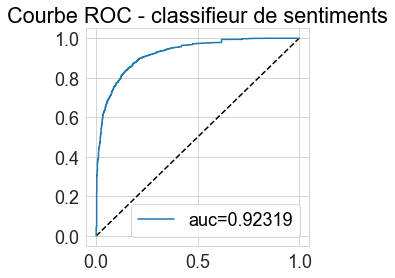

In [137]:
score = modelB_fit.predict_proba(feat_test)
fpr, tpr, th = roc_curve(y_test, score[:, 1])
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr, tpr)
ax.plot(fpr, tpr, label='auc=%1.5f' % aucf)
ax.set_title('Courbe ROC - classifieur de sentiments')
ax.legend();

In [ ]:
from sklearn.svm import SVC
param_grid = {#'C': [10, 50, 100,200],
              #'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','sigmoid']}

svm = SVC(random_state=42)

svm_grid = GridSearchCV(svm, param_grid, cv=3)

%time SVM = svm_grid.fit(feat_train, y_train)

print(svm_grid.best_score_.round(5))
print(svm_grid.best_params_)

In [ ]:
final_model = svm_grid.best_estimator_

In [ ]:
pred_train = final_model.predict(feat_train) 
pred_test = final_model.predict(feat_test)

In [ ]:
print(classification_report(y_train, pred_train))

In [ ]:
print(classification_report(y_test, pred_test))

In [ ]:
y_pred = MatriceConfusion(SVM)

In [ ]:
y_score = final_model.decision_function(feat_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
param_grid = {
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth":[400, 500],
    "criterion": ["friedman_mse", "mae", "mse"],
    'n_estimators' : [50, 70]}

gbc=GradientBoostingClassifier(random_state=42)

gbc_grid = GridSearchCV(gbc, param_grid, cv = 3)

%time GBC = gbc_grid.fit(feat_train, y_train)
print (gbc_grid.best_score_.round(5))
print(gbc_grid.best_params_)

final_model = gbc_grid.best_estimator_

pred_train = final_model.predict(feat_train) 
pred_test = final_model.predict(feat_test)

In [ ]:
print(classification_report(y_train, pred_train))

In [ ]:
print(classification_report(y_test, pred_test))

In [ ]:
y_pred = MatriceConfusion(GBC)

In [ ]:
score = final_model.predict_proba(feat_test)
fpr, tpr, th = roc_curve(y_test, score[:, 1])
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr, tpr)
ax.plot(fpr, tpr, label='auc=%1.5f' % aucf)
ax.set_title('Courbe ROC - classifieur de sentiments')
ax.legend();

In [ ]:
CHIEN + chet = 'tres'

In [ ]:
generated_ngrams = ngrams(word_tokenize(X_train.iloc[0,0]), 3, pad_left=True, pad_right=True)
list(generated_ngrams)[:7]

In [ ]:
pipe2 = make_pipeline(CountVectorizer(ngram_range=(1, 2)),
                      TfidfTransformer())
pipe2.fit(X_train['sentence'])
feat_train2 = pipe2.transform(X_train['sentence'])
feat_train2.shape

In [ ]:
cl = pipe2.steps[0]
cl[1].get_feature_names()[:10]

In [ ]:
feat_test2 = pipe2.transform(X_test['sentence'])

In [ ]:
clf2 = LogisticRegression()
clf2.fit(feat_train2, y_train)

In [ ]:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
clf2.score(feat_test2, y_test)

In [ ]:
pipe_svd = make_pipeline(CountVectorizer(), TruncatedSVD(n_components=300))
pipe_svd.fit(X_train['sentence'])
feat_train_svd = pipe_svd.transform(X_train['sentence'])
feat_train_svd.shape

In [ ]:
clf_svd = RandomForestClassifier(n_estimators=50, max_depth=40, random_state=42)
clf_svd.fit(feat_train_svd, y_train)

In [ ]:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
feat_test_svd = pipe_svd.transform(X_test['sentence'])
clf_svd.score(feat_test_svd, y_test)

In [ ]:
lr_svd = LogisticRegression()
lr_svd.fit(feat_train_svd, y_train)
lr_svd.score(feat_test_svd, y_test)

In [ ]:
pipe_svd_tfidf = make_pipeline(CountVectorizer(),
                     TfidfTransformer(),
                     TruncatedSVD(n_components=300))
pipe_svd_tfidf.fit(X_train['sentence'])
feat_train_svd_tfidf = pipe_svd_tfidf.transform(X_train['sentence'])

clf_svd_tfidf = LogisticRegression()
clf_svd_tfidf.fit(feat_train_svd_tfidf, y_train)

feat_test_svd_tfidf = pipe_svd_tfidf.transform(X_test['sentence'])
clf_svd_tfidf.score(feat_test_svd_tfidf, y_test)

In [ ]:
sentance = [list(tokenize(s, deacc=True, lower=True)) for s in X_train['sentence']]
sentance[0]

In [ ]:
model = word2vec.Word2Vec(sentance, size=300, window=20,
                          min_count=2, workers=1, iter=100)
model.corpus_count

In [ ]:
vocab = model.wv.vocab
list(vocab)[:5]

In [ ]:
model.save('trained_word2vec.bin')

In [ ]:
model.wv['exceptionnel'].shape, model.wv['exceptionnel'][:10]

In [ ]:
def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return numpy.zeros((model.vector_size,))

def sum_vectors(phrase, model):
    return sum(get_vect(w, model) for w in phrase)

def word2vec_features(X, model):
    feats = numpy.vstack([sum_vectors(p, model) for p in X])
    return feats

wv_train_feat = word2vec_features(X_train["sentence"], model)
wv_train_feat.shape

In [ ]:
clfwv = LogisticRegression(solver='lbfgs', max_iter=1000)
clfwv.fit(wv_train_feat, y_train)

In [ ]:
wv_test_feat = word2vec_features(X_test["sentence"], model)

In [ ]:
clfwv.score(wv_test_feat, y_test)

In [ ]:
words = list(sorted(model.wv.vocab))
words[:10]

In [ ]:
subset = ['exceptionnel', 'personnel', words[3], words[4], words[5]]
rows = []
for w in subset:
    for ww in subset:
        rows.append(dict(w1=w, w2=ww, d=model.wv.similarity(w, ww)))
import pandas
pandas.DataFrame(rows).pivot("w1", "w2", "d")

In [ ]:
# y variable dépendante et X variables indépendantes
#X = df.iloc[:, df.columns !='polaritecomments'].values
#y = df.iloc[:, 5].values

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
#print (X_train.shape,y_train.shape)
#print (X_test.shape, y_test.shape)

In [ ]:
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [ ]:
#train = pd.DataFrame(X_train)

In [ ]:
#train.hist(figsize=(13,50),color='blue',bins=40,layout=(8,3))
#plt.show()

In [ ]:
#param_grid = {'max_depth' : [3, 10, 15],
#    'random_state': [0, 42],
#             'n_estimators' : [10, 50]}
#grid = GridSearchCV( RandomForestClassifier(), param_grid)

#%time grid.fit(X_train, y_train)
#print(grid.best_params_)

#model = grid.best_estimator_
#yfit = model.predict(X_test)

In [ ]:
#weights = (y == 0).sum() / (1.0 * (y == 1).sum())

In [ ]:
#def get_score(model,X_train,X_test,y_train,y_test):
    #model.fit(X_train,y_train)
    #return model.score(X_test,y_test)

In [ ]:
kf = KFold(n_splits=3)

LR = LogisticRegression()
SVM = SVC()
NB = nb.BernoulliNB()
DTC = DecisionTreeClassifier(max_depth = 5, random_state= 42)
RF = RandomForestClassifier(max_depth = 5, n_estimators= 10, random_state= 42)
XGBC = XGBClassifier(max_depth = 5, scale_pos_weight = weights, \
                n_jobs = 4)

logis=list()
svm=list()
nb=list()
arb=list()
rfl=list()
clf=list()

for index_train, index_test in kf.split(d_model):
    X_train, X_test, y_train, y_test = X[index_train], X[index_test], y[index_train], y[index_test]
    logis.append(get_score(LR, X_train, X_test, y_train, y_test))
    svm.append(get_score(SVM, X_train, X_test, y_train, y_test))
    nb.append(get_score(NB, X_train, X_test, y_train, y_test))
    arb.append(get_score(DTC, X_train, X_test, y_train, y_test))
    rfl.append(get_score(RF, X_train, X_test, y_train, y_test))
    clf.append(get_score(XGBC, X_train, X_test, y_train, y_test))
    
print(np.mean(logis))
print(np.mean(svm))
print(np.mean(arb))
print(np.mean(rfl))
print(np.mean(clf))

In [ ]:
# y variable dépendante et X variables indépendantes
X = d_model.iloc[:, d_model.columns !='isFraud']
Y = d_model.iloc[:, 5]

X_t = pd.DataFrame(X_train)
feature_importances = pd.DataFrame(RF.feature_importances_, index = X.columns,columns=['importance']).sort_values('importance',ascending=False)
feature_importances

In [ ]:
features = X.columns
importances=RF.feature_importances_
indices=np.argsort(importances)
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('importance du score');
plt.ylabel('variables indépendantes');
plt.title('Ordre d\'importance des variables indépendantes');
plt.show()

In [ ]:
def MatriceConfusion (model):
    y_pred = model.predict(X_test)
    # Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.matshow(cm)
    plt.title('Matrice de confusion', y=1.12)
    plt.colorbar()
    print(cm)
    plt.show()

In [ ]:
y_pred = MatriceConfusion(LR)

In [ ]:
#NaiveBayes = muticlasses
#SVM = multiclasses